In [2]:
!nvidia-smi

Thu Feb 19 18:56:07 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.288.01             Driver Version: 535.288.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-DGXS-32GB           On  | 00000000:07:00.0 Off |                    0 |
| N/A   40C    P0              39W / 300W |     47MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install tensorflow

In [5]:
import os
import shutil
from pathlib import Path
# import imghdr
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import tensorflow as tf

In [6]:
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [7]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32
SEED = 42

data_dir = "standardized_256"  

import os

print("Current directory:", os.getcwd())
print("Files here:", os.listdir())

print("\nClasses inside dataset folder:")
print(os.listdir(data_dir))

Current directory: /home/palaniselvam/dlor
Files here: ['resnet50_tune_du256_do0p2_l20p0_hlr0p001_flr0p0001_unf10_ft.keras', 'resnet50_tune_du256_do0p2_l20p0_hlr0p001_flr0p0001_unf50_head.keras', 'baseline_exp2.keras', 'model1_baselinepp.keras', 'rs50_trial01_head.keras', 'efficientnetb0_head.keras', 'standardized_256.zip', 'standardized_256', 'project2.ipynb', 'mobilenetv2_head_clean.keras', '.ipynb_checkpoints', 'densenet121_finetune.keras', 'mobilenetv2_head.keras', 'mobilenetv2_finetune.keras', 'resnet50_best_search_log.json', 'efficientnetb0_finetune.keras', 'resnet50_head.keras', 'residual_cnn.keras', 'densenet121_head.keras', 'mobilenetv2_finetune_clean.keras', 'baseline.keras', 'resnet50_tune_du256_do0p2_l20p0_hlr0p001_flr0p0001_unf30_head.keras', 'resnet50_tune_du256_do0p2_l20p0_hlr0p001_flr0p0001_unf30_ft.keras', 'resnet50_finetune.keras', 'resnet50_tune_du256_do0p2_l20p0_hlr0p001_flr0p0001_unf10_head.keras']

Classes inside dataset folder:
['trash', 'paper', 'clothes', 'shoe

In [8]:
from pathlib import Path
from PIL import Image
import os

# Remove corrupted images
count = 0
image_extensions = [".png", ".jpg", ".jpeg"]
img_type_accepted_by_tf = ["BMP", "GIF", "JPEG", "PNG"]

for filepath in Path(data_dir).rglob("*"):
    
    if filepath.suffix.lower() in image_extensions:
        try:
            with Image.open(filepath) as img:
                img.verify()   # check corruption
                
            # reopen to get format (verify() closes file)
            with Image.open(filepath) as img:
                img_type = img.format  # e.g. 'JPEG', 'PNG'
            
            if img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is {img_type}, not accepted by TensorFlow. Removing.")
                os.remove(filepath)
                count += 1

        except Exception:
            print(f"{filepath} is corrupted. Removing.")
            os.remove(filepath)
            count += 1

print(f"Removed {count} invalid images")


Removed 0 invalid images


In [9]:
!pip install imagehash

## Remove duplicate

In [10]:
# Remove duplicate images
from PIL import Image
import imagehash

hashes = {}
duplicates = []

for root, _, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            path = os.path.join(root, file)
            try:
                img = Image.open(path).convert("RGB")
                h = imagehash.phash(img)

                if h in hashes:
                    duplicates.append(path)
                else:
                    hashes[h] = path
            except Exception as e:
                print(f"Error processing {path}: {e}")

for dup in duplicates:
    os.remove(dup)

print(f"Removed {len(duplicates)} duplicate images.")

Removed 0 duplicate images.


## Split dataset

In [11]:
#Train/test/val split
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32
SEED = 42

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

temp_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

temp_batches = tf.data.experimental.cardinality(temp_ds)
val_batches = temp_batches // 2

val_ds = temp_ds.take(val_batches)
test_ds = temp_ds.skip(val_batches)

print("Train batches:", tf.data.experimental.cardinality(train_ds))
print("Validation batches:", tf.data.experimental.cardinality(val_ds))
print("Test batches:", tf.data.experimental.cardinality(test_ds))

Found 13347 files belonging to 10 classes.
Using 10678 files for training.


2026-02-19 18:56:43.055842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31084 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2026-02-19 18:56:43.056488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31133 MB memory:  -> device: 1, name: Tesla V100-DGXS-32GB, pci bus id: 0000:08:00.0, compute capability: 7.0
2026-02-19 18:56:43.057073: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 31133 MB memory:  -> device: 2, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0e:00.0, compute capability: 7.0
2026-02-19 18:56:43.057666: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 31133 MB memory:  -> device: 3, name: Tesla V100-DGXS-32GB, pci bus id

Found 13347 files belonging to 10 classes.
Using 2669 files for validation.
Train batches: tf.Tensor(334, shape=(), dtype=int64)
Validation batches: tf.Tensor(42, shape=(), dtype=int64)
Test batches: tf.Tensor(42, shape=(), dtype=int64)


## Normalize dataset

In [12]:
# Normalization
from tensorflow.keras.layers import Rescaling

normalization_layer = Rescaling(1./255)

normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

print("All datasets normalized successfully.")

for dataset_name, dataset in [('normalized_train_ds', normalized_train_ds),
                               ('normalized_val_ds', normalized_val_ds),
                               ('normalized_test_ds', normalized_test_ds)]:
    for image_batch, labels_batch in dataset.take(1):
        print(f"\nMinimum pixel value in {dataset_name}: {image_batch.numpy().min()}")
        print(f"Maximum pixel value in {dataset_name}: {image_batch.numpy().max()}")

All datasets normalized successfully.

Minimum pixel value in normalized_train_ds: 0.0
Maximum pixel value in normalized_train_ds: 1.0

Minimum pixel value in normalized_val_ds: 0.0
Maximum pixel value in normalized_val_ds: 1.0

Minimum pixel value in normalized_test_ds: 0.0
Maximum pixel value in normalized_test_ds: 1.0


## Data Augmentation

In [13]:
# ----- Balance training dataset -----

LOW_TH = 1200
HIGH_TH = 1600
TARGET = 1400
AUTOTUNE = tf.data.AUTOTUNE

augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

train_unbatched = train_ds.unbatch()
class_names = train_ds.class_names
num_classes = len(class_names)

# count samples per class
counts = [0] * num_classes
for _, label in train_unbatched:
    counts[int(label.numpy())] += 1

print("Before balancing:")
for i in range(num_classes):
    print(class_names[i], ":", counts[i])

balanced_parts = []

for cid in range(num_classes):

    ds_class = train_unbatched.filter(
        lambda x, y, c=cid: tf.equal(y, c)
    )

    n = counts[cid]
    ds_class = ds_class.shuffle(max(1024, n))

    if n < LOW_TH:
        # oversample
        ds_class = ds_class.repeat()

        ds_class = ds_class.map(
            lambda x, y: (
                tf.squeeze(augment(tf.expand_dims(x, 0), training=True), axis=0),
                y
            ),
            num_parallel_calls=AUTOTUNE
        )

        ds_class = ds_class.take(TARGET)

    elif n > HIGH_TH:
        # undersample
        ds_class = ds_class.take(TARGET)

    else:
        ds_class = ds_class.take(min(n, TARGET))

    balanced_parts.append(ds_class)

# combine all classes
balanced_train_ds = balanced_parts[0]
for part in balanced_parts[1:]:
    balanced_train_ds = balanced_train_ds.concatenate(part)

balanced_train_ds = (
    balanced_train_ds
    .shuffle(5000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

print("\nBalanced dataset ready.")

# ----- Check counts after balancing -----

check_ds = balanced_train_ds.unbatch()
after_counts = [0] * num_classes

for _, label in check_ds:
    after_counts[int(label.numpy())] += 1

print("\nAfter balancing:")
for i in range(num_classes):
    print(class_names[i], ":", after_counts[i])


Before balancing:
battery : 663
biological : 649
cardboard : 1234
clothes : 1597
glass : 1588
metal : 790
paper : 1115
plastic : 1365
shoes : 1294
trash : 383

Balanced dataset ready.


2026-02-19 18:57:02.336399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-19 18:57:12.749200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 18:57:12.757795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



After balancing:
battery : 1400
biological : 1400
cardboard : 1234
clothes : 1400
glass : 1400
metal : 1400
paper : 1400
plastic : 1365
shoes : 1294
trash : 1400


In [14]:
import numpy as np

all_labels = []
for _, y in test_ds:
    all_labels.append(y.numpy())

all_labels = np.concatenate(all_labels)
print("unique labels:", np.unique(all_labels))
print("min:", all_labels.min(), "max:", all_labels.max())
print("counts:", np.bincount(all_labels, minlength=len(class_names)))

unique labels: [0 1 2 3 4 5 6 7 8 9]
min: 0 max: 9
counts: [ 68  81 156 192 216 113 114 165 166  54]


# Model Tuning 

## Model Selection Rationale
I want to compare different types of conv neural networks to find the best approach for distinguishing between visually similar material classes (paper-cardboard, metal-plastic, shoes-clothes). To do so i tested:
- a simple custom cnn (baseline to act as control)
- deeper custom model with residual connections
- 4 pretrained transfer learning models

### Baseline Custom CNN

I first implemented a standard convolutional neural network using repeated Conv → BatchNorm → ReLU → MaxPooling blocks followed by a dense classification head.

This model serves as a reference point. It helps answer:
- How well can a CNN trained from scratch perform on this dataset?
- Is transfer learning truly necessary?
- What is the inherent difficulty of the classification task?

---

### Residual CNN

To explore whether deeper architectures improve performance, I implemented a custom CNN with residual connections.

Residual connections allow gradients to flow more easily through deeper networks and help prevent vanishing gradient problems. The purpose was to test whether increased depth and skip connections could improve feature learning compared to the simpler baseline CNN.

---

### MobileNetV2 (Transfer Learning)

MobileNetV2 was selected as a lightweight pretrained model.

It is designed to be computationally efficient while still extracting strong visual features. Since the dataset contains around 14,000 images, transfer learning allows the model to leverage features learned from ImageNet.

This model represents an efficient and practical architecture suitable for real-world deployment scenarios.

---

### ResNet50 (Transfer Learning)

ResNet50 is a deeper residual network pretrained on ImageNet.

It was included to evaluate whether a larger and more expressive pretrained architecture could outperform lighter models. This provides a comparison between lightweight transfer learning (MobileNetV2) and deeper residual-based transfer learning.

---

### EfficientNetB0 (Transfer Learning)

EfficientNetB0 was chosen because it uses compound scaling, which balances depth, width, and resolution in a structured way.

It represents a more modern CNN design and is often known for achieving strong performance with relatively fewer parameters compared to older architectures.

---

### DenseNet121 (Transfer Learning)

DenseNet121 introduces dense connectivity, where each layer receives input from all previous layers.

This encourages feature reuse and can improve performance on fine-grained classification tasks where subtle differences matter. It was included to evaluate whether dense feature propagation benefits this waste classification problem.

---

## Overall Strategy

The selected models represent different architectural philosophies:

- A simple custom CNN baseline  
- A deeper residual custom model  
- Lightweight transfer learning (MobileNetV2)  
- Deep residual transfer learning (ResNet50)  
- Modern scaled architecture (EfficientNetB0)  
- Dense connectivity architecture (DenseNet121)  

By comparing accuracy, class-level precision and recall, and confusion matrices, I can determine which architectural design generalizes best for multi-class waste classification.

### Model evaluation metric function 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def evaluate_model(model, test_ds, class_names, title=None):
    if title is None:
        title = model.name

    loss, acc = model.evaluate(test_ds, verbose=1)
    print(f"\n{title} — loss: {loss:.4f}, accuracy: {acc:.4f}")

    y_true = []
    y_pred = []

    for x, y in test_ds:
        p = model.predict(x, verbose=0)
        y_true.append(y.numpy())
        y_pred.append(np.argmax(p, axis=1))

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    acc_check = accuracy_score(y_true, y_pred)
    print(f"{title} — accuracy_score: {acc_check:.4f}\n")

    labels = np.arange(len(class_names))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    print(classification_report(
        y_true,
        y_pred,
        labels=labels,
        target_names=class_names,
        digits=4,
        zero_division=0
    ))

    plt.figure(figsize=(9, 7))
    plt.imshow(cm)
    plt.title(f"Confusion Matrix — {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(labels, class_names, rotation=45, ha="right")
    plt.yticks(labels, class_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.show()

    return loss, acc, acc_check, cm

# Model 1 (Baseline from Part 1)

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Exp-2 settings (Part 1)
EXP_NAME = "baseline_exp2"
LR = 3e-4
EPOCHS = 25

num_classes = len(train_ds.class_names)

# (Optional but recommended for repeatability)
tf.random.set_seed(42)

# Exp-2 model architecture from Part 1 (Flatten + Dense(128))
model_exp2 = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Block 1
    layers.Conv2D(32, (3, 3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.10),   # light

    # Block 2
    layers.Conv2D(64, (3, 3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.20),   # light

    # Block 3
    layers.Conv2D(128, (3, 3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.30),   # light

    layers.Flatten(),

    layers.Dense(128, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.40),   # light head dropout

    layers.Dense(num_classes, activation="softmax")
])

model_exp2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        f"{EXP_NAME}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
]

print("Training Exp-2...")
history = model_exp2.fit(
    balanced_train_ds,     # keep your balanced pipeline
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("Evaluating on test set...")
best_model = tf.keras.models.load_model(f"{EXP_NAME}.keras")
test_loss, test_acc = best_model.evaluate(test_ds, verbose=1)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

Training Exp-2...
Epoch 1/25


2026-02-18 17:18:44.391058: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_25/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2026-02-18 17:18:56.724648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-18 17:19:06.894915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-18 17:19:06.897363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


    428/Unknown - 76s 119ms/step - loss: 1.3772 - accuracy: 0.5723
Epoch 1: val_accuracy improved from -inf to 0.36756, saving model to baseline_exp2.keras
428/428 [==============================] - 78s 125ms/step - loss: 1.3772 - accuracy: 0.5723 - val_loss: 2.0092 - val_accuracy: 0.3676 - lr: 3.0000e-04
Epoch 2/25


2026-02-18 17:20:14.314171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 24s - loss: 1.7012 - accuracy: 0.3750

2026-02-18 17:20:25.474826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 1.0183 - accuracy: 0.6671
Epoch 2: val_accuracy improved from 0.36756 to 0.44568, saving model to baseline_exp2.keras
428/428 [==============================] - 76s 122ms/step - loss: 1.0183 - accuracy: 0.6671 - val_loss: 1.8402 - val_accuracy: 0.4457 - lr: 3.0000e-04
Epoch 3/25


2026-02-18 17:21:29.416620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 23s - loss: 1.5599 - accuracy: 0.4062

2026-02-18 17:21:39.489309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-18 17:21:39.491754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.8725 - accuracy: 0.7121
Epoch 3: val_accuracy did not improve from 0.44568
428/428 [==============================] - 75s 124ms/step - loss: 0.8725 - accuracy: 0.7121 - val_loss: 2.4379 - val_accuracy: 0.3140 - lr: 3.0000e-04
Epoch 4/25


2026-02-18 17:22:44.338812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 24s - loss: 1.1482 - accuracy: 0.5833

2026-02-18 17:22:53.618107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.7679 - accuracy: 0.7428
Epoch 4: val_accuracy did not improve from 0.44568

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
428/428 [==============================] - 72s 119ms/step - loss: 0.7679 - accuracy: 0.7428 - val_loss: 1.8725 - val_accuracy: 0.4152 - lr: 3.0000e-04
Epoch 5/25


2026-02-18 17:23:56.091633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 23s - loss: 1.3813 - accuracy: 0.5312

2026-02-18 17:24:06.269372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-18 17:24:06.272120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6854 - accuracy: 0.7722
Epoch 5: val_accuracy improved from 0.44568 to 0.48363, saving model to baseline_exp2.keras
428/428 [==============================] - 74s 122ms/step - loss: 0.6854 - accuracy: 0.7722 - val_loss: 1.7867 - val_accuracy: 0.4836 - lr: 1.5000e-04
Epoch 6/25


2026-02-18 17:25:10.785625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 24s - loss: 0.9579 - accuracy: 0.7083

2026-02-18 17:25:20.435340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6229 - accuracy: 0.7926
Epoch 6: val_accuracy did not improve from 0.48363
428/428 [==============================] - 74s 122ms/step - loss: 0.6229 - accuracy: 0.7926 - val_loss: 1.7873 - val_accuracy: 0.4717 - lr: 1.5000e-04
Epoch 7/25


2026-02-18 17:26:24.117189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 23s - loss: 1.1078 - accuracy: 0.5521

2026-02-18 17:26:33.537030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.5910 - accuracy: 0.8030
Epoch 7: val_accuracy improved from 0.48363 to 0.50595, saving model to baseline_exp2.keras
428/428 [==============================] - 73s 122ms/step - loss: 0.5910 - accuracy: 0.8030 - val_loss: 1.7695 - val_accuracy: 0.5060 - lr: 1.5000e-04
Epoch 8/25


2026-02-18 17:27:37.267353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 23s - loss: 0.9077 - accuracy: 0.6979

2026-02-18 17:27:45.864828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.8191
Epoch 8: val_accuracy improved from 0.50595 to 0.52753, saving model to baseline_exp2.keras
428/428 [==============================] - 71s 119ms/step - loss: 0.5459 - accuracy: 0.8191 - val_loss: 1.7660 - val_accuracy: 0.5275 - lr: 1.5000e-04
Epoch 9/25


2026-02-18 17:28:48.674441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 23s - loss: 0.9195 - accuracy: 0.6875

2026-02-18 17:28:57.437777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.5163 - accuracy: 0.8311
Epoch 9: val_accuracy improved from 0.52753 to 0.53646, saving model to baseline_exp2.keras
428/428 [==============================] - 72s 122ms/step - loss: 0.5163 - accuracy: 0.8311 - val_loss: 1.7275 - val_accuracy: 0.5365 - lr: 1.5000e-04
Epoch 10/25


2026-02-18 17:30:01.329915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 24s - loss: 0.9830 - accuracy: 0.6667

2026-02-18 17:30:11.516189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-18 17:30:11.518890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.4868 - accuracy: 0.8425
Epoch 10: val_accuracy improved from 0.53646 to 0.53720, saving model to baseline_exp2.keras
428/428 [==============================] - 73s 121ms/step - loss: 0.4868 - accuracy: 0.8425 - val_loss: 1.6011 - val_accuracy: 0.5372 - lr: 1.5000e-04
Epoch 11/25


2026-02-18 17:31:14.543585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 22s - loss: 0.8598 - accuracy: 0.7083

2026-02-18 17:31:23.172457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.4679 - accuracy: 0.8428
Epoch 11: val_accuracy did not improve from 0.53720
428/428 [==============================] - 70s 117ms/step - loss: 0.4679 - accuracy: 0.8428 - val_loss: 2.0542 - val_accuracy: 0.5030 - lr: 1.5000e-04
Epoch 12/25


2026-02-18 17:32:25.430972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 23s - loss: 0.7992 - accuracy: 0.6354

2026-02-18 17:32:35.962561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-18 17:32:35.966233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.4389 - accuracy: 0.8550
Epoch 12: val_accuracy did not improve from 0.53720

Epoch 12: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
428/428 [==============================] - 73s 119ms/step - loss: 0.4389 - accuracy: 0.8550 - val_loss: 1.7313 - val_accuracy: 0.5365 - lr: 1.5000e-04
Epoch 13/25


2026-02-18 17:33:38.639178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 23s - loss: 0.8685 - accuracy: 0.7083

2026-02-18 17:33:47.565228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.4215 - accuracy: 0.8621
Epoch 13: val_accuracy improved from 0.53720 to 0.54836, saving model to baseline_exp2.keras
428/428 [==============================] - 71s 118ms/step - loss: 0.4215 - accuracy: 0.8621 - val_loss: 1.6283 - val_accuracy: 0.5484 - lr: 7.5000e-05
Epoch 14/25


2026-02-18 17:34:50.088878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 24s - loss: 0.7069 - accuracy: 0.7500

2026-02-18 17:35:00.297363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-18 17:35:00.300282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3960 - accuracy: 0.8697
Epoch 14: val_accuracy improved from 0.54836 to 0.54985, saving model to baseline_exp2.keras

Epoch 14: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
428/428 [==============================] - 73s 120ms/step - loss: 0.3960 - accuracy: 0.8697 - val_loss: 1.7859 - val_accuracy: 0.5499 - lr: 7.5000e-05
Epoch 15/25


2026-02-18 17:36:03.764638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 23s - loss: 0.5081 - accuracy: 0.8229

2026-02-18 17:36:12.830973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3935 - accuracy: 0.8730
Epoch 15: val_accuracy did not improve from 0.54985
428/428 [==============================] - 71s 117ms/step - loss: 0.3935 - accuracy: 0.8730 - val_loss: 1.9658 - val_accuracy: 0.5320 - lr: 3.7500e-05
Epoch 16/25


2026-02-18 17:37:13.636055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 22s - loss: 0.7498 - accuracy: 0.7604

2026-02-18 17:37:22.052754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3729 - accuracy: 0.8804
Epoch 16: val_accuracy did not improve from 0.54985

Epoch 16: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
428/428 [==============================] - 69s 117ms/step - loss: 0.3729 - accuracy: 0.8804 - val_loss: 1.8264 - val_accuracy: 0.5491 - lr: 3.7500e-05
Epoch 17/25


2026-02-18 17:38:23.720543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 23s - loss: 0.6408 - accuracy: 0.7604

2026-02-18 17:38:32.907276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3738 - accuracy: 0.8787
Epoch 17: val_accuracy did not improve from 0.54985
428/428 [==============================] - 71s 119ms/step - loss: 0.3738 - accuracy: 0.8787 - val_loss: 1.7634 - val_accuracy: 0.5409 - lr: 1.8750e-05
Epoch 18/25


2026-02-18 17:39:34.773985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 24s - loss: 0.5205 - accuracy: 0.8333

2026-02-18 17:39:43.877892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3718 - accuracy: 0.8790
Epoch 18: val_accuracy did not improve from 0.54985

Epoch 18: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.
428/428 [==============================] - 71s 119ms/step - loss: 0.3718 - accuracy: 0.8790 - val_loss: 1.9039 - val_accuracy: 0.5402 - lr: 1.8750e-05
Epoch 19/25


2026-02-18 17:40:47.000002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:753: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 23s - loss: 0.4582 - accuracy: 0.8125

2026-02-18 17:40:56.034526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3683 - accuracy: 0.8814
Epoch 19: val_accuracy did not improve from 0.54985
Restoring model weights from the end of the best epoch: 14.
428/428 [==============================] - 71s 117ms/step - loss: 0.3683 - accuracy: 0.8814 - val_loss: 1.9013 - val_accuracy: 0.5335 - lr: 9.3750e-06
Epoch 19: early stopping
Evaluating on test set...
42/42 [==============================] - 1s 14ms/step - loss: 1.6522 - accuracy: 0.5774
Test Accuracy: 0.5773584842681885
Test Loss: 1.652152180671692


42/42 [==============================] - 3s 32ms/step - loss: 1.6374 - accuracy: 0.5781

baseline_exp2 — loss: 1.6374, accuracy: 0.5781
baseline_exp2 — accuracy_score: 0.5796

              precision    recall  f1-score   support

     battery     1.0000    0.2254    0.3678        71
  biological     0.6923    0.4557    0.5496        79
   cardboard     0.8387    0.5455    0.6610       143
     clothes     0.7424    0.8901    0.8095       191
       glass     0.5804    0.6637    0.6192       223
       metal     0.4627    0.2793    0.3483       111
       paper     0.3846    0.0855    0.1399       117
     plastic     0.4131    0.7500    0.5328       168
       shoes     0.5447    0.8383    0.6604       167
       trash     0.5200    0.2364    0.3250        55

    accuracy                         0.5796      1325
   macro avg     0.6179    0.4970    0.5014      1325
weighted avg     0.6054    0.5796    0.5505      1325



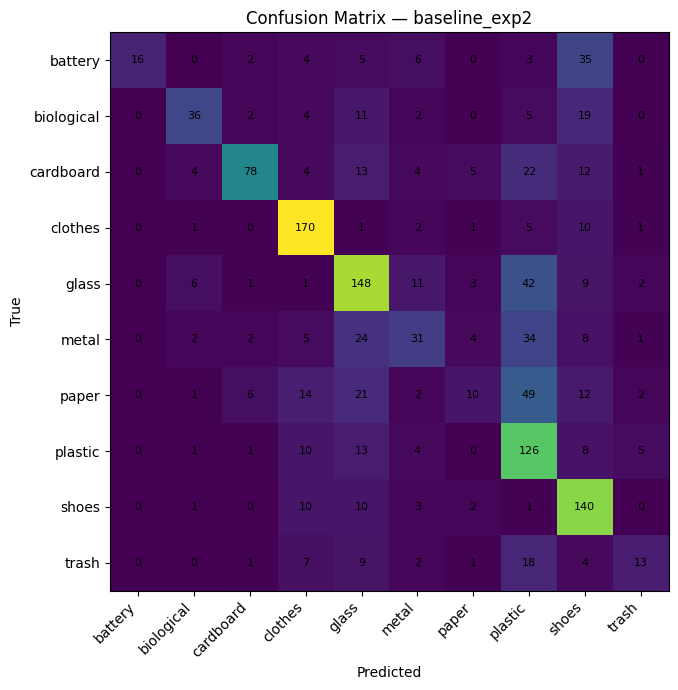

(1.637434959411621,
 0.5781131982803345,
 0.579622641509434,
 array([[ 16,   0,   2,   4,   5,   6,   0,   3,  35,   0],
        [  0,  36,   2,   4,  11,   2,   0,   5,  19,   0],
        [  0,   4,  78,   4,  13,   4,   5,  22,  12,   1],
        [  0,   1,   0, 170,   1,   2,   1,   5,  10,   1],
        [  0,   6,   1,   1, 148,  11,   3,  42,   9,   2],
        [  0,   2,   2,   5,  24,  31,   4,  34,   8,   1],
        [  0,   1,   6,  14,  21,   2,  10,  49,  12,   2],
        [  0,   1,   1,  10,  13,   4,   0, 126,   8,   5],
        [  0,   1,   0,  10,  10,   3,   2,   1, 140,   0],
        [  0,   0,   1,   7,   9,   2,   1,  18,   4,  13]]))

In [23]:
baseline_exp2 = tf.keras.models.load_model(
    "baseline_exp2.keras",
    safe_mode=False
)

evaluate_model(
    baseline_exp2,
    test_ds,
    train_ds.class_names,
    title="baseline_exp2"
)

In [51]:
# Evaluate on all splits
train_loss, train_acc = baseline_exp2.evaluate(train_ds, verbose=0)
val_loss, val_acc     = baseline_exp2.evaluate(val_ds, verbose=0)
test_loss, test_acc   = baseline_exp2.evaluate(test_ds, verbose=0)

print("Train Accuracy:", round(train_acc, 4))
print("Val Accuracy:  ", round(val_acc, 4))
print("Test Accuracy: ", round(test_acc, 4))

print("Train Loss:", round(train_loss, 4))
print("Val Loss:  ", round(val_loss, 4))
print("Test Loss: ", round(test_loss, 4))

2026-02-19 14:37:15.041567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-19 14:37:26.191780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2026-02-19 14:38:05.450058: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4946832620135172539
2026-02-19 14:38:05.450136: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 310522370854800497


Train Accuracy: 0.8652
Val Accuracy:   0.5432
Test Accuracy:  0.5781
Train Loss: 0.3951
Val Loss:   1.7954
Test Loss:  1.6446


# Residual 

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

train_ds = balanced_train_ds

def make_callbacks(model_name, patience_es=8, patience_rlr=3):
    return [
        keras.callbacks.ModelCheckpoint(
            filepath=f"{model_name}.keras",
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=patience_es,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=patience_rlr,
            min_lr=1e-6,
            verbose=1
        ),
    ]

def res_block(x, filters, stride=1):
    shortcut = x

    x = layers.Conv2D(filters, 3, strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same", use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Stem
x = layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Residual stacks
x = res_block(x, 32)
x = res_block(x, 32)

x = res_block(x, 64, stride=2)
x = res_block(x, 64)

x = res_block(x, 128, stride=2)
x = res_block(x, 128)

x = res_block(x, 192, stride=2)
x = res_block(x, 192)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

residual_cnn = keras.Model(inputs, outputs, name="residual_cnn")

residual_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

history_residual = residual_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    verbose=1,
    callbacks=make_callbacks("residual_cnn")
)

test_loss, test_acc = residual_cnn.evaluate(test_ds, verbose=1)
print(f"[residual_cnn] Test accuracy: {test_acc:.4f}")

Epoch 1/50


2026-02-19 11:06:05.445428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-19 11:06:16.163582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


    428/Unknown - 94s 135ms/step - loss: 1.2843 - accuracy: 0.5451
Epoch 1: val_accuracy improved from -inf to 0.34226, saving model to residual_cnn.keras
428/428 [==============================] - 96s 140ms/step - loss: 1.2843 - accuracy: 0.5451 - val_loss: 3.1366 - val_accuracy: 0.3423 - lr: 3.0000e-04
Epoch 2/50


2026-02-19 11:07:35.880367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  2/428 [..............................] - ETA: 29s - loss: 2.0425 - accuracy: 0.2969    

2026-02-19 11:07:46.452612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 11:07:46.455966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.9887 - accuracy: 0.6477
Epoch 2: val_accuracy did not improve from 0.34226
428/428 [==============================] - 76s 127ms/step - loss: 0.9887 - accuracy: 0.6477 - val_loss: 2.9746 - val_accuracy: 0.2716 - lr: 3.0000e-04
Epoch 3/50


2026-02-19 11:08:51.774429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 28s - loss: 1.5772 - accuracy: 0.4583

2026-02-19 11:09:01.775214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.8811 - accuracy: 0.6851
Epoch 3: val_accuracy improved from 0.34226 to 0.35863, saving model to residual_cnn.keras
428/428 [==============================] - 75s 127ms/step - loss: 0.8811 - accuracy: 0.6851 - val_loss: 2.4327 - val_accuracy: 0.3586 - lr: 3.0000e-04
Epoch 4/50


2026-02-19 11:10:06.771122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  2/428 [..............................] - ETA: 30s - loss: 2.1506 - accuracy: 0.3125    

2026-02-19 11:10:16.880798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 11:10:16.884728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.8164 - accuracy: 0.7080
Epoch 4: val_accuracy improved from 0.35863 to 0.42188, saving model to residual_cnn.keras
428/428 [==============================] - 75s 127ms/step - loss: 0.8164 - accuracy: 0.7080 - val_loss: 2.6067 - val_accuracy: 0.4219 - lr: 3.0000e-04
Epoch 5/50


2026-02-19 11:11:21.919825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 27s - loss: 1.5212 - accuracy: 0.4583

2026-02-19 11:11:31.048764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.7446 - accuracy: 0.7340
Epoch 5: val_accuracy did not improve from 0.42188
428/428 [==============================] - 72s 123ms/step - loss: 0.7446 - accuracy: 0.7340 - val_loss: 3.8121 - val_accuracy: 0.3735 - lr: 3.0000e-04
Epoch 6/50


2026-02-19 11:12:34.568692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  2/428 [..............................] - ETA: 29s - loss: 1.6944 - accuracy: 0.4219    

2026-02-19 11:12:43.794014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.7532
Epoch 6: val_accuracy did not improve from 0.42188

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
428/428 [==============================] - 73s 123ms/step - loss: 0.6928 - accuracy: 0.7532 - val_loss: 3.1820 - val_accuracy: 0.3430 - lr: 3.0000e-04
Epoch 7/50


2026-02-19 11:13:47.142097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 28s - loss: 1.8176 - accuracy: 0.3958

2026-02-19 11:13:55.893607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6157 - accuracy: 0.7846
Epoch 7: val_accuracy improved from 0.42188 to 0.47173, saving model to residual_cnn.keras
428/428 [==============================] - 73s 125ms/step - loss: 0.6157 - accuracy: 0.7846 - val_loss: 2.2036 - val_accuracy: 0.4717 - lr: 1.5000e-04
Epoch 8/50


2026-02-19 11:15:00.069904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  2/428 [..............................] - ETA: 30s - loss: 1.4010 - accuracy: 0.4375    

2026-02-19 11:15:08.592710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.5680 - accuracy: 0.8006
Epoch 8: val_accuracy improved from 0.47173 to 0.48810, saving model to residual_cnn.keras
428/428 [==============================] - 72s 123ms/step - loss: 0.5680 - accuracy: 0.8006 - val_loss: 2.2512 - val_accuracy: 0.4881 - lr: 1.5000e-04
Epoch 9/50


2026-02-19 11:16:12.027418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 27s - loss: 1.1281 - accuracy: 0.5000

2026-02-19 11:16:20.346104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.5234 - accuracy: 0.8114
Epoch 9: val_accuracy did not improve from 0.48810
428/428 [==============================] - 71s 121ms/step - loss: 0.5234 - accuracy: 0.8114 - val_loss: 1.8637 - val_accuracy: 0.4874 - lr: 1.5000e-04
Epoch 10/50


2026-02-19 11:17:22.979119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  2/428 [..............................] - ETA: 30s - loss: 0.8898 - accuracy: 0.7344    

2026-02-19 11:17:31.816404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.4955 - accuracy: 0.8251
Epoch 10: val_accuracy did not improve from 0.48810
428/428 [==============================] - 72s 123ms/step - loss: 0.4955 - accuracy: 0.8251 - val_loss: 3.3540 - val_accuracy: 0.4673 - lr: 1.5000e-04
Epoch 11/50


2026-02-19 11:18:35.358781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 28s - loss: 0.9382 - accuracy: 0.6042

2026-02-19 11:18:43.666994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.4784 - accuracy: 0.8314
Epoch 11: val_accuracy did not improve from 0.48810
428/428 [==============================] - 71s 122ms/step - loss: 0.4784 - accuracy: 0.8314 - val_loss: 3.0738 - val_accuracy: 0.4680 - lr: 1.5000e-04
Epoch 12/50


2026-02-19 11:19:46.641124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  2/428 [..............................] - ETA: 30s - loss: 0.7628 - accuracy: 0.6719    

2026-02-19 11:19:54.973857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.4516 - accuracy: 0.8440
Epoch 12: val_accuracy did not improve from 0.48810

Epoch 12: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
428/428 [==============================] - 71s 122ms/step - loss: 0.4516 - accuracy: 0.8440 - val_loss: 2.9256 - val_accuracy: 0.4487 - lr: 1.5000e-04
Epoch 13/50


2026-02-19 11:20:57.737892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 28s - loss: 0.9917 - accuracy: 0.6146

2026-02-19 11:21:06.277039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.4021 - accuracy: 0.8606
Epoch 13: val_accuracy improved from 0.48810 to 0.53423, saving model to residual_cnn.keras
428/428 [==============================] - 72s 124ms/step - loss: 0.4021 - accuracy: 0.8606 - val_loss: 2.4892 - val_accuracy: 0.5342 - lr: 7.5000e-05
Epoch 14/50


2026-02-19 11:22:10.231337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 28s - loss: 0.9465 - accuracy: 0.6667

2026-02-19 11:22:18.662145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3798 - accuracy: 0.8702
Epoch 14: val_accuracy did not improve from 0.53423
428/428 [==============================] - 71s 121ms/step - loss: 0.3798 - accuracy: 0.8702 - val_loss: 3.1639 - val_accuracy: 0.5164 - lr: 7.5000e-05
Epoch 15/50


2026-02-19 11:23:21.136330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 28s - loss: 0.7060 - accuracy: 0.7396

2026-02-19 11:23:29.474417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3594 - accuracy: 0.8744
Epoch 15: val_accuracy did not improve from 0.53423

Epoch 15: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
428/428 [==============================] - 71s 122ms/step - loss: 0.3594 - accuracy: 0.8744 - val_loss: 3.2258 - val_accuracy: 0.5171 - lr: 7.5000e-05
Epoch 16/50


2026-02-19 11:24:32.423901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 27s - loss: 0.8518 - accuracy: 0.6562

2026-02-19 11:24:40.781130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3502 - accuracy: 0.8763
Epoch 16: val_accuracy improved from 0.53423 to 0.55208, saving model to residual_cnn.keras
428/428 [==============================] - 72s 124ms/step - loss: 0.3502 - accuracy: 0.8763 - val_loss: 2.4837 - val_accuracy: 0.5521 - lr: 3.7500e-05
Epoch 17/50


2026-02-19 11:25:44.469673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  2/428 [..............................] - ETA: 30s - loss: 0.5563 - accuracy: 0.7969    

2026-02-19 11:25:52.760760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3246 - accuracy: 0.8861
Epoch 17: val_accuracy did not improve from 0.55208
428/428 [==============================] - 72s 124ms/step - loss: 0.3246 - accuracy: 0.8861 - val_loss: 2.6922 - val_accuracy: 0.5506 - lr: 3.7500e-05
Epoch 18/50


2026-02-19 11:26:56.834310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 28s - loss: 0.7706 - accuracy: 0.7604

2026-02-19 11:27:05.611186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3209 - accuracy: 0.8869
Epoch 18: val_accuracy improved from 0.55208 to 0.56399, saving model to residual_cnn.keras

Epoch 18: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
428/428 [==============================] - 72s 122ms/step - loss: 0.3209 - accuracy: 0.8869 - val_loss: 2.4114 - val_accuracy: 0.5640 - lr: 3.7500e-05
Epoch 19/50


2026-02-19 11:28:08.857280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  2/428 [..............................] - ETA: 30s - loss: 0.7036 - accuracy: 0.7500    

2026-02-19 11:28:17.831016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3136 - accuracy: 0.8910
Epoch 19: val_accuracy did not improve from 0.56399
428/428 [==============================] - 73s 123ms/step - loss: 0.3136 - accuracy: 0.8910 - val_loss: 2.6778 - val_accuracy: 0.5625 - lr: 1.8750e-05
Epoch 20/50


2026-02-19 11:29:21.394602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 28s - loss: 0.7210 - accuracy: 0.6979

2026-02-19 11:29:29.935303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3113 - accuracy: 0.8902
Epoch 20: val_accuracy did not improve from 0.56399
428/428 [==============================] - 72s 124ms/step - loss: 0.3113 - accuracy: 0.8902 - val_loss: 3.2168 - val_accuracy: 0.5506 - lr: 1.8750e-05
Epoch 21/50


2026-02-19 11:30:33.442980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  2/428 [..............................] - ETA: 29s - loss: 0.4474 - accuracy: 0.8438    

2026-02-19 11:30:41.791236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3013 - accuracy: 0.8953
Epoch 21: val_accuracy did not improve from 0.56399

Epoch 21: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.
428/428 [==============================] - 72s 124ms/step - loss: 0.3013 - accuracy: 0.8953 - val_loss: 3.0142 - val_accuracy: 0.5528 - lr: 1.8750e-05
Epoch 22/50


2026-02-19 11:31:45.484568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 28s - loss: 0.5582 - accuracy: 0.7500

2026-02-19 11:31:54.499206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3069 - accuracy: 0.8900
Epoch 22: val_accuracy did not improve from 0.56399
428/428 [==============================] - 73s 124ms/step - loss: 0.3069 - accuracy: 0.8900 - val_loss: 2.9375 - val_accuracy: 0.5551 - lr: 9.3750e-06
Epoch 23/50


2026-02-19 11:32:58.289485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  2/428 [..............................] - ETA: 29s - loss: 0.3717 - accuracy: 0.8281    

2026-02-19 11:33:07.124554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.2946 - accuracy: 0.8945
Epoch 23: val_accuracy did not improve from 0.56399
428/428 [==============================] - 73s 124ms/step - loss: 0.2946 - accuracy: 0.8945 - val_loss: 3.0994 - val_accuracy: 0.5558 - lr: 9.3750e-06
Epoch 24/50


2026-02-19 11:34:11.376660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 28s - loss: 0.7714 - accuracy: 0.7292

2026-02-19 11:34:20.321046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.2957 - accuracy: 0.8977
Epoch 24: val_accuracy did not improve from 0.56399

Epoch 24: ReduceLROnPlateau reducing learning rate to 4.687500222644303e-06.
428/428 [==============================] - 72s 122ms/step - loss: 0.2957 - accuracy: 0.8977 - val_loss: 2.9275 - val_accuracy: 0.5640 - lr: 9.3750e-06
Epoch 25/50


2026-02-19 11:35:23.421327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  2/428 [..............................] - ETA: 29s - loss: 0.4517 - accuracy: 0.7969    

2026-02-19 11:35:32.068813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3012 - accuracy: 0.8941
Epoch 25: val_accuracy did not improve from 0.56399
428/428 [==============================] - 73s 125ms/step - loss: 0.3012 - accuracy: 0.8941 - val_loss: 3.1515 - val_accuracy: 0.5491 - lr: 4.6875e-06
Epoch 26/50


2026-02-19 11:36:36.264594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 27s - loss: 0.4769 - accuracy: 0.8125

2026-02-19 11:36:44.784695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.8937
Epoch 26: val_accuracy did not improve from 0.56399
Restoring model weights from the end of the best epoch: 18.
428/428 [==============================] - 73s 125ms/step - loss: 0.3008 - accuracy: 0.8937 - val_loss: 2.9775 - val_accuracy: 0.5558 - lr: 4.6875e-06
Epoch 26: early stopping
42/42 [==============================] - 2s 33ms/step - loss: 2.2688 - accuracy: 0.5615
[residual_cnn] Test accuracy: 0.5615


42/42 [==============================] - 2s 21ms/step - loss: 2.3417 - accuracy: 0.5502

residual_cnn — loss: 2.3417, accuracy: 0.5502
residual_cnn — accuracy_score: 0.5638

              precision    recall  f1-score   support

     battery     0.8333    0.0685    0.1266        73
  biological     0.8000    0.0580    0.1081        69
   cardboard     0.6615    0.8323    0.7371       155
     clothes     0.8594    0.8639    0.8616       191
       glass     0.6542    0.6452    0.6497       217
       metal     1.0000    0.0696    0.1301       115
       paper     0.5714    0.0345    0.0650       116
     plastic     0.3636    0.8727    0.5134       165
       shoes     0.4755    0.8144    0.6004       167
       trash     0.7500    0.2105    0.3288        57

    accuracy                         0.5638      1325
   macro avg     0.6969    0.4469    0.4121      1325
weighted avg     0.6703    0.5638    0.5002      1325



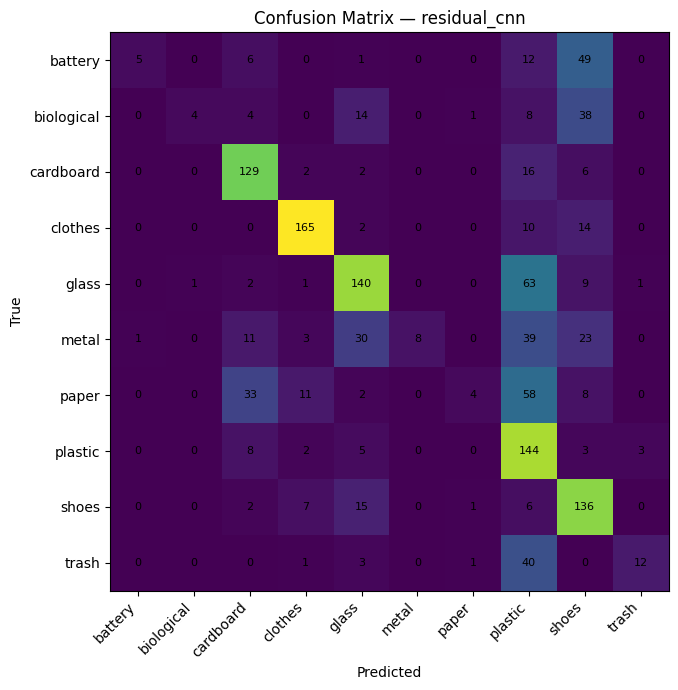

(2.3417210578918457,
 0.5501886606216431,
 0.5637735849056604,
 array([[  5,   0,   6,   0,   1,   0,   0,  12,  49,   0],
        [  0,   4,   4,   0,  14,   0,   1,   8,  38,   0],
        [  0,   0, 129,   2,   2,   0,   0,  16,   6,   0],
        [  0,   0,   0, 165,   2,   0,   0,  10,  14,   0],
        [  0,   1,   2,   1, 140,   0,   0,  63,   9,   1],
        [  1,   0,  11,   3,  30,   8,   0,  39,  23,   0],
        [  0,   0,  33,  11,   2,   0,   4,  58,   8,   0],
        [  0,   0,   8,   2,   5,   0,   0, 144,   3,   3],
        [  0,   0,   2,   7,  15,   0,   1,   6, 136,   0],
        [  0,   0,   0,   1,   3,   0,   1,  40,   0,  12]]))

In [31]:
residual_cnn = tf.keras.models.load_model(
    "residual_cnn.keras",
    safe_mode=False
)

evaluate_model(
    residual_cnn,
    test_ds,
    class_names,
    title="residual_cnn"
)

In [54]:
# Evaluate on all splits
train_loss, train_acc = residual_cnn.evaluate(train_ds, verbose=0)
val_loss, val_acc     = residual_cnn.evaluate(val_ds, verbose=0)
test_loss, test_acc   = residual_cnn.evaluate(test_ds, verbose=0)

print("Train Accuracy:", round(train_acc, 4))
print("Val Accuracy:  ", round(val_acc, 4))
print("Test Accuracy: ", round(test_acc, 4))

print("Train Loss:", round(train_loss, 4))
print("Val Loss:  ", round(val_loss, 4))
print("Test Loss: ", round(test_loss, 4))

2026-02-19 14:40:38.113420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-19 14:40:47.951584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


Train Accuracy: 0.8832
Val Accuracy:   0.5476
Test Accuracy:  0.5509
Train Loss: 0.3152
Val Loss:   2.4405
Test Loss:  2.3529


# MobileNetV2 transfer learning

In [64]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

train_ds = balanced_train_ds  # your balanced train dataset

def make_callbacks(model_name, patience_es=6, patience_rlr=2):
    return [
        keras.callbacks.ModelCheckpoint(
            filepath=f"{model_name}.keras",
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=patience_es,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.2,
            patience=patience_rlr,
            min_lr=1e-6,
            verbose=1
        ),
    ]

@keras.utils.register_keras_serializable()
class MobileNetV2Preprocess(layers.Layer):
    def call(self, x):
        return tf.keras.applications.mobilenet_v2.preprocess_input(x)

def build_mobilenetv2(num_classes, img_height, img_width, dropout=0.3):
    inputs = keras.Input(shape=(img_height, img_width, 3), name="image")

    # assumes dataset images are in [0,1]
    x = layers.Rescaling(255.0, name="to_255")(inputs)
    x = MobileNetV2Preprocess(name="mbv2_preprocess")(x)

    base = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_tensor=x
    )
    base.trainable = False

    x = base.output
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.Dropout(dropout, name="dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = keras.Model(inputs, outputs, name="mobilenetv2")
    return model, base

# -----------------------
# Retrain from scratch
# -----------------------
mobilenetv2, base = build_mobilenetv2(
    num_classes=num_classes,
    img_height=IMG_HEIGHT,
    img_width=IMG_WIDTH,
    dropout=0.3
)

# Stage 1: train head
mobilenetv2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history_head = mobilenetv2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    verbose=1,
    callbacks=make_callbacks("mobilenetv2_head_clean", patience_es=6, patience_rlr=2)
)

# Stage 2: fine-tune (unfreeze last N layers; keep BN frozen)
base.trainable = True

N_UNFREEZE = 30
for layer in base.layers[:-N_UNFREEZE]:
    layer.trainable = False

for layer in base.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

mobilenetv2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history_ft = mobilenetv2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=make_callbacks("mobilenetv2_finetune_clean", patience_es=5, patience_rlr=2)
)

# Evaluate best saved fine-tune checkpoint (same filename every run)
mbv2_best = tf.keras.models.load_model("mobilenetv2_finetune_clean.keras", safe_mode=False)
test_loss, test_acc = mbv2_best.evaluate(test_ds, verbose=1)
print("mobilenetv2_finetune_clean test_acc:", round(float(test_acc), 4))
print("mobilenetv2_finetune_clean test_loss:", round(float(test_loss), 4))

Epoch 1/15


2026-02-19 15:30:40.423525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-19 15:30:51.114889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


    427/Unknown - 68s 98ms/step - loss: 1.3461 - accuracy: 0.5300
Epoch 1: val_accuracy improved from -inf to 0.47991, saving model to mobilenetv2_head_clean.keras
428/428 [==============================] - 71s 104ms/step - loss: 1.3465 - accuracy: 0.5298 - val_loss: 1.4753 - val_accuracy: 0.4799 - lr: 0.0010
Epoch 2/15


2026-02-19 15:31:48.101054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  7/428 [..............................] - ETA: 11s - loss: 1.1570 - accuracy: 0.6250

2026-02-19 15:31:56.907873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.9954 - accuracy: 0.6644
Epoch 2: val_accuracy improved from 0.47991 to 0.50298, saving model to mobilenetv2_head_clean.keras
428/428 [==============================] - 63s 99ms/step - loss: 0.9953 - accuracy: 0.6644 - val_loss: 1.4667 - val_accuracy: 0.5030 - lr: 0.0010
Epoch 3/15


2026-02-19 15:32:50.608968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  7/428 [..............................] - ETA: 11s - loss: 0.9299 - accuracy: 0.6830

2026-02-19 15:33:00.618969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 15:33:00.621836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.9091 - accuracy: 0.6920
Epoch 3: val_accuracy improved from 0.50298 to 0.60417, saving model to mobilenetv2_head_clean.keras
428/428 [==============================] - 63s 97ms/step - loss: 0.9091 - accuracy: 0.6920 - val_loss: 1.2613 - val_accuracy: 0.6042 - lr: 0.0010
Epoch 4/15


2026-02-19 15:33:53.840002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  7/428 [..............................] - ETA: 11s - loss: 0.8808 - accuracy: 0.7188

2026-02-19 15:34:02.861634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.8511 - accuracy: 0.7086
Epoch 4: val_accuracy did not improve from 0.60417
428/428 [==============================] - 61s 95ms/step - loss: 0.8517 - accuracy: 0.7084 - val_loss: 1.2950 - val_accuracy: 0.5677 - lr: 0.0010
Epoch 5/15


2026-02-19 15:34:54.490121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  7/428 [..............................] - ETA: 11s - loss: 0.9194 - accuracy: 0.7232

2026-02-19 15:35:04.136130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.8266 - accuracy: 0.7135
Epoch 5: val_accuracy improved from 0.60417 to 0.60789, saving model to mobilenetv2_head_clean.keras
428/428 [==============================] - 61s 96ms/step - loss: 0.8265 - accuracy: 0.7134 - val_loss: 1.2106 - val_accuracy: 0.6079 - lr: 0.0010
Epoch 6/15


2026-02-19 15:35:56.422908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  7/428 [..............................] - ETA: 11s - loss: 0.8283 - accuracy: 0.7500

2026-02-19 15:36:05.122674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


426/428 [============================>.] - ETA: 0s - loss: 0.8019 - accuracy: 0.7265
Epoch 6: val_accuracy did not improve from 0.60789
428/428 [==============================] - 60s 94ms/step - loss: 0.8021 - accuracy: 0.7265 - val_loss: 1.2847 - val_accuracy: 0.5863 - lr: 0.0010
Epoch 7/15


2026-02-19 15:36:56.160977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  7/428 [..............................] - ETA: 12s - loss: 0.8554 - accuracy: 0.7366

2026-02-19 15:37:05.326301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.7993 - accuracy: 0.7280
Epoch 7: val_accuracy did not improve from 0.60789

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
428/428 [==============================] - 60s 94ms/step - loss: 0.7993 - accuracy: 0.7280 - val_loss: 1.2851 - val_accuracy: 0.6034 - lr: 0.0010
Epoch 8/15


2026-02-19 15:37:56.986351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  7/428 [..............................] - ETA: 11s - loss: 0.9319 - accuracy: 0.6920

2026-02-19 15:38:05.499253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.8012 - accuracy: 0.7308
Epoch 8: val_accuracy did not improve from 0.60789
428/428 [==============================] - 59s 92ms/step - loss: 0.8014 - accuracy: 0.7306 - val_loss: 1.2756 - val_accuracy: 0.5893 - lr: 2.0000e-04
Epoch 9/15


2026-02-19 15:38:56.328638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  7/428 [..............................] - ETA: 11s - loss: 1.0297 - accuracy: 0.6696

2026-02-19 15:39:05.179866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.7897 - accuracy: 0.7298
Epoch 9: val_accuracy improved from 0.60789 to 0.61012, saving model to mobilenetv2_head_clean.keras

Epoch 9: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
428/428 [==============================] - 62s 98ms/step - loss: 0.7897 - accuracy: 0.7298 - val_loss: 1.2448 - val_accuracy: 0.6101 - lr: 2.0000e-04
Epoch 10/15


2026-02-19 15:39:58.345030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  7/428 [..............................] - ETA: 11s - loss: 1.1140 - accuracy: 0.6250

2026-02-19 15:40:08.039499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.8538 - accuracy: 0.7128
Epoch 10: val_accuracy did not improve from 0.61012
428/428 [==============================] - 62s 96ms/step - loss: 0.8538 - accuracy: 0.7128 - val_loss: 1.2985 - val_accuracy: 0.5923 - lr: 4.0000e-05
Epoch 11/15


2026-02-19 15:41:00.891010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  7/428 [..............................] - ETA: 11s - loss: 1.0619 - accuracy: 0.6339

2026-02-19 15:41:11.168883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 15:41:11.171809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.8591 - accuracy: 0.7057
Epoch 11: val_accuracy improved from 0.61012 to 0.61086, saving model to mobilenetv2_head_clean.keras

Epoch 11: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
428/428 [==============================] - 63s 97ms/step - loss: 0.8591 - accuracy: 0.7057 - val_loss: 1.2329 - val_accuracy: 0.6109 - lr: 4.0000e-05
Epoch 12/15


2026-02-19 15:42:04.103306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  6/428 [..............................] - ETA: 10s - loss: 0.9722 - accuracy: 0.7083

2026-02-19 15:42:13.037160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.9168 - accuracy: 0.6866
Epoch 12: val_accuracy improved from 0.61086 to 0.61161, saving model to mobilenetv2_head_clean.keras
428/428 [==============================] - 61s 94ms/step - loss: 0.9168 - accuracy: 0.6866 - val_loss: 1.2320 - val_accuracy: 0.6116 - lr: 8.0000e-06
Epoch 13/15


2026-02-19 15:43:04.723847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  7/428 [..............................] - ETA: 11s - loss: 0.9321 - accuracy: 0.7009

2026-02-19 15:43:13.197114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.8989 - accuracy: 0.6921
Epoch 13: val_accuracy did not improve from 0.61161

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
428/428 [==============================] - 60s 95ms/step - loss: 0.8989 - accuracy: 0.6921 - val_loss: 1.2175 - val_accuracy: 0.6034 - lr: 8.0000e-06
Epoch 14/15


2026-02-19 15:44:04.779435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  7/428 [..............................] - ETA: 11s - loss: 0.9233 - accuracy: 0.6830

2026-02-19 15:44:14.619327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.8896 - accuracy: 0.6963
Epoch 14: val_accuracy did not improve from 0.61161
428/428 [==============================] - 62s 97ms/step - loss: 0.8896 - accuracy: 0.6963 - val_loss: 1.1927 - val_accuracy: 0.6109 - lr: 1.6000e-06
Epoch 15/15


2026-02-19 15:45:06.969523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  7/428 [..............................] - ETA: 11s - loss: 0.7761 - accuracy: 0.7232

2026-02-19 15:45:15.565122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.8902 - accuracy: 0.6945
Epoch 15: val_accuracy did not improve from 0.61161
428/428 [==============================] - 60s 95ms/step - loss: 0.8902 - accuracy: 0.6945 - val_loss: 1.2211 - val_accuracy: 0.6057 - lr: 1.6000e-06
Epoch 1/10


2026-02-19 15:46:12.999896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-19 15:46:23.569166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


    428/Unknown - 73s 104ms/step - loss: 0.8469 - accuracy: 0.7052
Epoch 1: val_accuracy improved from -inf to 0.60565, saving model to mobilenetv2_finetune_clean.keras
428/428 [==============================] - 76s 111ms/step - loss: 0.8469 - accuracy: 0.7052 - val_loss: 1.4061 - val_accuracy: 0.6057 - lr: 1.0000e-04
Epoch 2/10


2026-02-19 15:47:24.669731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 14s - loss: 0.4926 - accuracy: 0.8438

2026-02-19 15:47:35.030465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 15:47:35.034354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6387 - accuracy: 0.7768
Epoch 2: val_accuracy did not improve from 0.60565
428/428 [==============================] - 66s 101ms/step - loss: 0.6387 - accuracy: 0.7768 - val_loss: 1.5643 - val_accuracy: 0.5685 - lr: 1.0000e-04
Epoch 3/10


2026-02-19 15:48:29.902510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 13s - loss: 0.4527 - accuracy: 0.8313

2026-02-19 15:48:38.594938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.5386 - accuracy: 0.8108
Epoch 3: val_accuracy improved from 0.60565 to 0.61905, saving model to mobilenetv2_finetune_clean.keras

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
428/428 [==============================] - 62s 100ms/step - loss: 0.5386 - accuracy: 0.8108 - val_loss: 1.4424 - val_accuracy: 0.6190 - lr: 1.0000e-04
Epoch 4/10


2026-02-19 15:49:32.777558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 13s - loss: 0.7448 - accuracy: 0.7437

2026-02-19 15:49:41.812111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3900 - accuracy: 0.8607
Epoch 4: val_accuracy improved from 0.61905 to 0.64286, saving model to mobilenetv2_finetune_clean.keras
428/428 [==============================] - 64s 101ms/step - loss: 0.3900 - accuracy: 0.8607 - val_loss: 1.4569 - val_accuracy: 0.6429 - lr: 2.0000e-05
Epoch 5/10


2026-02-19 15:50:37.094316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 13s - loss: 0.4644 - accuracy: 0.8438

2026-02-19 15:50:45.956025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.8780
Epoch 5: val_accuracy did not improve from 0.64286

Epoch 5: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
428/428 [==============================] - 64s 100ms/step - loss: 0.3451 - accuracy: 0.8780 - val_loss: 1.5252 - val_accuracy: 0.6369 - lr: 2.0000e-05
Epoch 6/10


2026-02-19 15:51:40.555598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 14s - loss: 0.3852 - accuracy: 0.8750

2026-02-19 15:51:50.464709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3316 - accuracy: 0.8841
Epoch 6: val_accuracy improved from 0.64286 to 0.66592, saving model to mobilenetv2_finetune_clean.keras
428/428 [==============================] - 64s 100ms/step - loss: 0.3316 - accuracy: 0.8841 - val_loss: 1.2960 - val_accuracy: 0.6659 - lr: 4.0000e-06
Epoch 7/10


2026-02-19 15:52:45.025803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 13s - loss: 0.4162 - accuracy: 0.8687

2026-02-19 15:52:54.949889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.8855
Epoch 7: val_accuracy improved from 0.66592 to 0.67113, saving model to mobilenetv2_finetune_clean.keras
428/428 [==============================] - 63s 98ms/step - loss: 0.3257 - accuracy: 0.8855 - val_loss: 1.2603 - val_accuracy: 0.6711 - lr: 4.0000e-06
Epoch 8/10


2026-02-19 15:53:48.717527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 14s - loss: 0.4171 - accuracy: 0.8562

2026-02-19 15:53:57.640776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3164 - accuracy: 0.8886
Epoch 8: val_accuracy did not improve from 0.67113
428/428 [==============================] - 61s 96ms/step - loss: 0.3164 - accuracy: 0.8886 - val_loss: 1.2564 - val_accuracy: 0.6696 - lr: 4.0000e-06
Epoch 9/10


2026-02-19 15:54:49.886106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 13s - loss: 0.4104 - accuracy: 0.8562

2026-02-19 15:54:58.416031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.8934
Epoch 9: val_accuracy did not improve from 0.67113
428/428 [==============================] - 61s 97ms/step - loss: 0.3008 - accuracy: 0.8934 - val_loss: 1.3698 - val_accuracy: 0.6674 - lr: 4.0000e-06
Epoch 10/10


2026-02-19 15:55:50.849459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 14s - loss: 0.3661 - accuracy: 0.8875

2026-02-19 15:56:00.593461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.2991 - accuracy: 0.8966
Epoch 10: val_accuracy did not improve from 0.67113

Epoch 10: ReduceLROnPlateau reducing learning rate to 1e-06.
42/42 [==============================] - 3s 25ms/step - loss: 1.2595 - accuracy: 0.6860
mobilenetv2_finetune_clean test_acc: 0.686
mobilenetv2_finetune_clean test_loss: 1.2595


42/42 [==============================] - 3s 26ms/step - loss: 1.2481 - accuracy: 0.6906

mobilenetv2_finetune — loss: 1.2481, accuracy: 0.6906
mobilenetv2_finetune — accuracy_score: 0.6770

              precision    recall  f1-score   support

     battery     0.9200    0.6765    0.7797        68
  biological     0.8684    0.4177    0.5641        79
   cardboard     0.7622    0.8621    0.8091       145
     clothes     0.8698    0.8789    0.8743       190
       glass     0.6214    0.6802    0.6495       222
       metal     0.6111    0.2056    0.3077       107
       paper     0.6591    0.2566    0.3694       113
     plastic     0.4706    0.7771    0.5862       175
       shoes     0.7330    0.9419    0.8244       172
       trash     0.5417    0.4815    0.5098        54

    accuracy                         0.6770      1325
   macro avg     0.7057    0.6178    0.6274      1325
weighted avg     0.6962    0.6770    0.6580      1325



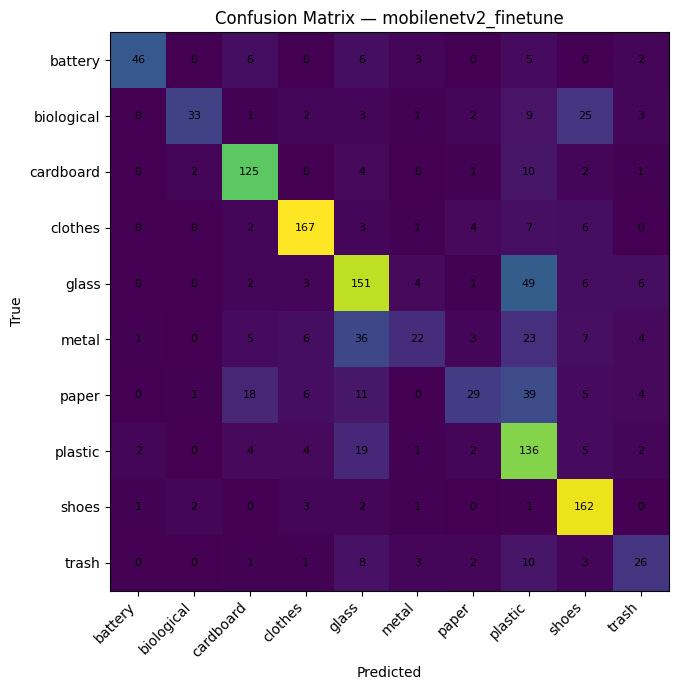

(1.2481001615524292,
 0.6905660629272461,
 0.6769811320754717,
 array([[ 46,   0,   6,   0,   6,   3,   0,   5,   0,   2],
        [  0,  33,   1,   2,   3,   1,   2,   9,  25,   3],
        [  0,   2, 125,   0,   4,   0,   1,  10,   2,   1],
        [  0,   0,   2, 167,   3,   1,   4,   7,   6,   0],
        [  0,   0,   2,   3, 151,   4,   1,  49,   6,   6],
        [  1,   0,   5,   6,  36,  22,   3,  23,   7,   4],
        [  0,   1,  18,   6,  11,   0,  29,  39,   5,   4],
        [  2,   0,   4,   4,  19,   1,   2, 136,   5,   2],
        [  1,   2,   0,   3,   2,   1,   0,   1, 162,   0],
        [  0,   0,   1,   1,   8,   3,   2,  10,   3,  26]]))

In [66]:
mobilenetv2 = tf.keras.models.load_model(
    "mobilenetv2_finetune.keras",
    safe_mode=False
)

evaluate_model(
    mobilenetv2,
    test_ds,
    class_names,
    title="mobilenetv2_finetune"
)

In [67]:
# Evaluate on all splits
train_loss, train_acc = mobilenetv2.evaluate(train_ds, verbose=0)
val_loss, val_acc     = mobilenetv2.evaluate(val_ds, verbose=0)
test_loss, test_acc   = mobilenetv2.evaluate(test_ds, verbose=0)

print("Train Accuracy:", round(train_acc, 4))
print("Val Accuracy:  ", round(val_acc, 4))
print("Test Accuracy: ", round(test_acc, 4))

print("Train Loss:", round(train_loss, 4))
print("Val Loss:  ", round(val_loss, 4))
print("Test Loss: ", round(test_loss, 4))

2026-02-19 16:01:36.401868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-19 16:01:46.674299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 16:01:46.677303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


Train Accuracy: 0.8863
Val Accuracy:   0.6823
Test Accuracy:  0.686
Train Loss: 0.3203
Val Loss:   1.3122
Test Loss:  1.2567


# EfficientNetB0 transfer learning

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

train_ds = balanced_train_ds

def make_callbacks(model_name, patience_es=6, patience_rlr=2):
    return [
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=patience_es,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.2,
            patience=patience_rlr,
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=f"{model_name}.keras",
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1
        ),
    ]

@keras.utils.register_keras_serializable()
class EfficientNetPreprocess(layers.Layer):
    def call(self, x):
        return tf.keras.applications.efficientnet.preprocess_input(x)

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="image")

# Your dataset is already scaled to [0,1] (Rescaling(1./255) in pipeline).
# EfficientNet preprocess_input is applied consistently here.
x = EfficientNetPreprocess(name="effb0_preprocess")(inputs)

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=x
)
base.trainable = False

x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

efficientnetb0 = keras.Model(inputs, outputs, name="efficientnetb0")

# --------------------
# Stage 1: head training
# --------------------
efficientnetb0.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history_effb0_head = efficientnetb0.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    verbose=1,
    callbacks=make_callbacks("efficientnetb0_head", patience_es=6, patience_rlr=2)
)

# --------------------
# Stage 2: fine-tuning (gentle)
# --------------------
base.trainable = True

# unfreeze last 10 layers only
for layer in base.layers[:-10]:
    layer.trainable = False

# freeze BN layers for stability
for layer in base.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

efficientnetb0.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history_effb0_ft = efficientnetb0.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=make_callbacks("efficientnetb0_finetune", patience_es=5, patience_rlr=2)
)

# --------------------
# Test evaluation (best fine-tune checkpoint)
# --------------------
best_effb0 = tf.keras.models.load_model("efficientnetb0_finetune.keras")
best_effb0.evaluate(test_ds, verbose=1)

Epoch 1/15


2026-02-19 10:44:22.422423: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2026-02-19 10:44:35.107179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-19 10:44:45.537640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 10:44:45.540096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2026-02-19 10:44:46.378023: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe7fd7e8910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-19 10:44:46.378062: I external/local_xla/xla/service/service.cc:176]   Str

    428/Unknown - 73s 101ms/step - loss: 0.5170 - accuracy: 0.8537
Epoch 1: val_accuracy improved from -inf to 0.87202, saving model to efficientnetb0_head.keras
428/428 [==============================] - 78s 113ms/step - loss: 0.5170 - accuracy: 0.8537 - val_loss: 0.3774 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 2/15


2026-02-19 10:45:47.048505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 15s - loss: 0.2385 - accuracy: 0.9187

2026-02-19 10:45:57.450390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 10:45:57.455370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.2416 - accuracy: 0.9230
Epoch 2: val_accuracy improved from 0.87202 to 0.90104, saving model to efficientnetb0_head.keras
428/428 [==============================] - 68s 108ms/step - loss: 0.2416 - accuracy: 0.9230 - val_loss: 0.3086 - val_accuracy: 0.9010 - lr: 0.0010
Epoch 3/15


2026-02-19 10:46:54.929124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 15s - loss: 0.2188 - accuracy: 0.9187

2026-02-19 10:47:04.859679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.2055 - accuracy: 0.9332
Epoch 3: val_accuracy did not improve from 0.90104
428/428 [==============================] - 68s 109ms/step - loss: 0.2059 - accuracy: 0.9330 - val_loss: 0.2918 - val_accuracy: 0.8996 - lr: 0.0010
Epoch 4/15


2026-02-19 10:48:03.037442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 16s - loss: 0.1270 - accuracy: 0.9563

2026-02-19 10:48:12.490906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.1839 - accuracy: 0.9398
Epoch 4: val_accuracy improved from 0.90104 to 0.90923, saving model to efficientnetb0_head.keras
428/428 [==============================] - 66s 105ms/step - loss: 0.1839 - accuracy: 0.9398 - val_loss: 0.2749 - val_accuracy: 0.9092 - lr: 0.0010
Epoch 5/15


2026-02-19 10:49:09.022673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 16s - loss: 0.1687 - accuracy: 0.9688

2026-02-19 10:49:18.389056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 0.9478
Epoch 5: val_accuracy did not improve from 0.90923
428/428 [==============================] - 67s 108ms/step - loss: 0.1617 - accuracy: 0.9478 - val_loss: 0.2686 - val_accuracy: 0.9085 - lr: 0.0010
Epoch 6/15


2026-02-19 10:50:15.962978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 13s - loss: 0.1026 - accuracy: 0.9625

2026-02-19 10:50:25.402783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.9488
Epoch 6: val_accuracy did not improve from 0.90923
428/428 [==============================] - 66s 106ms/step - loss: 0.1550 - accuracy: 0.9488 - val_loss: 0.2734 - val_accuracy: 0.9025 - lr: 0.0010
Epoch 7/15


2026-02-19 10:51:21.832942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 16s - loss: 0.1305 - accuracy: 0.9500

2026-02-19 10:51:31.574065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.1405 - accuracy: 0.9534
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 7: val_accuracy did not improve from 0.90923
428/428 [==============================] - 65s 103ms/step - loss: 0.1405 - accuracy: 0.9533 - val_loss: 0.2876 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 8/15


2026-02-19 10:52:26.574062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 15s - loss: 0.0779 - accuracy: 0.9688

2026-02-19 10:52:34.860471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.1506 - accuracy: 0.9506
Epoch 8: val_accuracy did not improve from 0.90923
428/428 [==============================] - 63s 103ms/step - loss: 0.1506 - accuracy: 0.9506 - val_loss: 0.2503 - val_accuracy: 0.9092 - lr: 2.0000e-04
Epoch 9/15


2026-02-19 10:53:30.217784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 15s - loss: 0.1008 - accuracy: 0.9625

2026-02-19 10:53:39.491923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.9512
Epoch 9: val_accuracy did not improve from 0.90923
428/428 [==============================] - 65s 103ms/step - loss: 0.1446 - accuracy: 0.9511 - val_loss: 0.2690 - val_accuracy: 0.9040 - lr: 2.0000e-04
Epoch 10/15


2026-02-19 10:54:34.449192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 15s - loss: 0.0698 - accuracy: 0.9812

2026-02-19 10:54:43.543998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.1443 - accuracy: 0.9516Restoring model weights from the end of the best epoch: 4.

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 10: val_accuracy did not improve from 0.90923
428/428 [==============================] - 64s 104ms/step - loss: 0.1443 - accuracy: 0.9516 - val_loss: 0.2606 - val_accuracy: 0.9048 - lr: 2.0000e-04
Epoch 10: early stopping
Epoch 1/10


2026-02-19 10:55:34.871375: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2026-02-19 10:55:47.010413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-19 10:55:57.472559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 10:55:57.478242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


    427/Unknown - 75s 104ms/step - loss: 0.1725 - accuracy: 0.9438
Epoch 1: val_accuracy improved from -inf to 0.90104, saving model to efficientnetb0_finetune.keras
428/428 [==============================] - 79s 115ms/step - loss: 0.1731 - accuracy: 0.9435 - val_loss: 0.2810 - val_accuracy: 0.9010 - lr: 1.0000e-05
Epoch 2/10


2026-02-19 10:56:58.985591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 16s - loss: 0.1228 - accuracy: 0.9688

2026-02-19 10:57:08.963043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.9460
Epoch 2: val_accuracy improved from 0.90104 to 0.90551, saving model to efficientnetb0_finetune.keras
428/428 [==============================] - 70s 113ms/step - loss: 0.1623 - accuracy: 0.9460 - val_loss: 0.2762 - val_accuracy: 0.9055 - lr: 1.0000e-05
Epoch 3/10


2026-02-19 10:58:08.691312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 17s - loss: 0.1683 - accuracy: 0.9563

2026-02-19 10:58:18.210928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.9495
Epoch 3: val_accuracy improved from 0.90551 to 0.90625, saving model to efficientnetb0_finetune.keras
428/428 [==============================] - 68s 110ms/step - loss: 0.1514 - accuracy: 0.9495 - val_loss: 0.2757 - val_accuracy: 0.9062 - lr: 1.0000e-05
Epoch 4/10


2026-02-19 10:59:15.910808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 16s - loss: 0.0527 - accuracy: 0.9812

2026-02-19 10:59:24.828816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.1533 - accuracy: 0.9491
Epoch 4: val_accuracy improved from 0.90625 to 0.91071, saving model to efficientnetb0_finetune.keras
428/428 [==============================] - 65s 107ms/step - loss: 0.1534 - accuracy: 0.9490 - val_loss: 0.2676 - val_accuracy: 0.9107 - lr: 1.0000e-05
Epoch 5/10


2026-02-19 11:00:21.961718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 16s - loss: 0.0978 - accuracy: 0.9563

2026-02-19 11:00:30.907282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.1445 - accuracy: 0.9509
Epoch 5: val_accuracy did not improve from 0.91071
428/428 [==============================] - 64s 103ms/step - loss: 0.1445 - accuracy: 0.9509 - val_loss: 0.2666 - val_accuracy: 0.9085 - lr: 1.0000e-05
Epoch 6/10


2026-02-19 11:01:25.620751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 18s - loss: 0.0371 - accuracy: 0.9896    

2026-02-19 11:01:34.915273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.9555
Epoch 6: val_accuracy did not improve from 0.91071
428/428 [==============================] - 66s 107ms/step - loss: 0.1383 - accuracy: 0.9555 - val_loss: 0.2713 - val_accuracy: 0.9062 - lr: 1.0000e-05
Epoch 7/10


2026-02-19 11:02:31.363424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 16s - loss: 0.0597 - accuracy: 0.9688

2026-02-19 11:02:40.272084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.1292 - accuracy: 0.9564
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.

Epoch 7: val_accuracy did not improve from 0.91071
428/428 [==============================] - 65s 107ms/step - loss: 0.1291 - accuracy: 0.9564 - val_loss: 0.2732 - val_accuracy: 0.9048 - lr: 1.0000e-05
Epoch 8/10


2026-02-19 11:03:36.938957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  1/428 [..............................] - ETA: 2:17:55 - loss: 0.0047 - accuracy: 1.0000

2026-02-19 11:03:45.552626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.1302 - accuracy: 0.9569
Epoch 8: val_accuracy did not improve from 0.91071
428/428 [==============================] - 65s 106ms/step - loss: 0.1302 - accuracy: 0.9568 - val_loss: 0.2638 - val_accuracy: 0.9077 - lr: 2.0000e-06
Epoch 9/10


2026-02-19 11:04:42.035549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  5/428 [..............................] - ETA: 16s - loss: 0.0798 - accuracy: 0.9625

2026-02-19 11:04:50.358703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9571Restoring model weights from the end of the best epoch: 4.

Epoch 9: val_accuracy did not improve from 0.91071
428/428 [==============================] - 65s 108ms/step - loss: 0.1293 - accuracy: 0.9571 - val_loss: 0.2620 - val_accuracy: 0.9048 - lr: 2.0000e-06
Epoch 9: early stopping
42/42 [==============================] - 4s 36ms/step - loss: 0.2751 - accuracy: 0.9064


[0.2751397490501404, 0.9064151048660278]

42/42 [==============================] - 4s 34ms/step - loss: 0.2733 - accuracy: 0.9072

efficientnetb0_finetune — loss: 0.2733, accuracy: 0.9072
efficientnetb0_finetune — accuracy_score: 0.9079

              precision    recall  f1-score   support

     battery     0.9851    0.9706    0.9778        68
  biological     0.9737    0.9610    0.9673        77
   cardboard     0.9032    0.9091    0.9061       154
     clothes     0.9895    0.9895    0.9895       191
       glass     0.9137    0.8612    0.8867       209
       metal     0.8812    0.7876    0.8318       113
       paper     0.9038    0.8103    0.8545       116
     plastic     0.7800    0.9070    0.8387       172
       shoes     0.9657    0.9941    0.9797       170
       trash     0.7797    0.8364    0.8070        55

    accuracy                         0.9079      1325
   macro avg     0.9076    0.9027    0.9039      1325
weighted avg     0.9107    0.9079    0.9080      1325



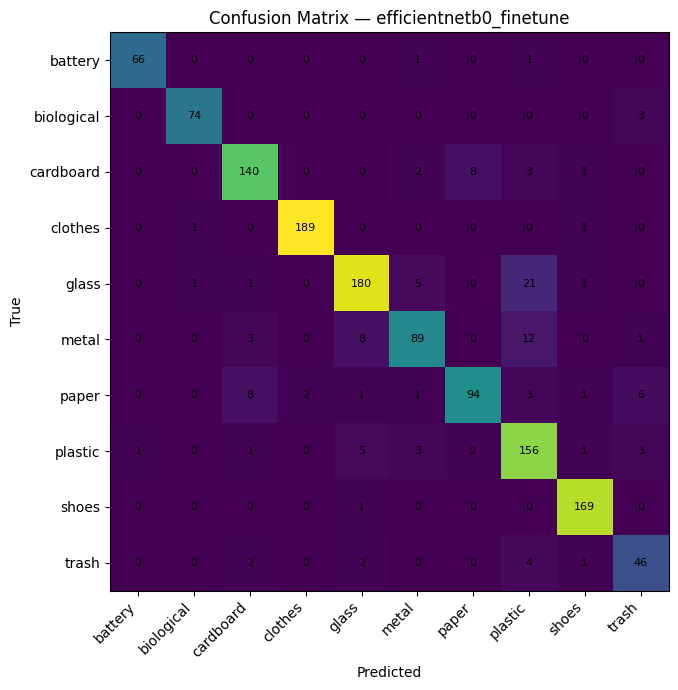

(0.2733187973499298,
 0.9071698188781738,
 0.9079245283018867,
 array([[ 66,   0,   0,   0,   0,   1,   0,   1,   0,   0],
        [  0,  74,   0,   0,   0,   0,   0,   0,   0,   3],
        [  0,   0, 140,   0,   0,   2,   8,   3,   1,   0],
        [  0,   1,   0, 189,   0,   0,   0,   0,   1,   0],
        [  0,   1,   1,   0, 180,   5,   0,  21,   1,   0],
        [  0,   0,   3,   0,   8,  89,   0,  12,   0,   1],
        [  0,   0,   8,   2,   1,   1,  94,   3,   1,   6],
        [  1,   0,   1,   0,   5,   3,   2, 156,   1,   3],
        [  0,   0,   0,   0,   1,   0,   0,   0, 169,   0],
        [  0,   0,   2,   0,   2,   0,   0,   4,   1,  46]]))

In [33]:
efficientnetb0 = tf.keras.models.load_model(
    "efficientnetb0_finetune.keras",
    safe_mode=False
)

evaluate_model(
    efficientnetb0,
    test_ds,
    class_names,
    title="efficientnetb0_finetune"
)

In [47]:
# Evaluate on all splits
train_loss, train_acc = efficientnetb0.evaluate(train_ds, verbose=0)
val_loss, val_acc     = efficientnetb0.evaluate(val_ds, verbose=0)
test_loss, test_acc   = efficientnetb0.evaluate(test_ds, verbose=0)

print("Train Accuracy:", round(train_acc, 4))
print("Val Accuracy:  ", round(val_acc, 4))
print("Test Accuracy: ", round(test_acc, 4))

print("Train Loss:", round(train_loss, 4))
print("Val Loss:  ", round(val_loss, 4))
print("Test Loss: ", round(test_loss, 4))

2026-02-19 13:43:47.463464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-19 13:43:57.740709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 13:43:57.743135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


Train Accuracy: 0.9641
Val Accuracy:   0.9062
Test Accuracy:  0.9094
Train Loss: 0.1121
Val Loss:   0.2763
Test Loss:  0.2688


# ResNet50 transfer learning

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

train_ds = balanced_train_ds  # already defined
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

def make_callbacks(model_name, patience_es=6, patience_rlr=2):
    return [
        keras.callbacks.ModelCheckpoint(
            filepath=f"{model_name}.keras",
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=patience_es,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=patience_rlr,
            min_lr=1e-6,
            verbose=1
        ),
    ]

# --------------------------------------------------
# Model Definition
# --------------------------------------------------

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Dataset is already 0–255 → DO NOT multiply again
x = layers.Lambda(tf.keras.applications.resnet50.preprocess_input)(inputs)

base = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=x
)

base.trainable = False

x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

resnet50 = keras.Model(inputs, outputs, name="resnet50")

# --------------------------------------------------
# Stage 1 — Train classifier head
# --------------------------------------------------

resnet50.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

resnet50.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    verbose=1,
    callbacks=make_callbacks("resnet50_head")
)

# --------------------------------------------------
# Stage 2 — Fine-tune last 15 layers
# --------------------------------------------------

base.trainable = True

for layer in base.layers[:-15]:
    layer.trainable = False

for layer in base.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

resnet50.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-6),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

resnet50.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1,
    callbacks=make_callbacks("resnet50_finetune")
)

# --------------------------------------------------
# Final Test Evaluation
# --------------------------------------------------

test_loss, test_acc = resnet50.evaluate(test_ds, verbose=1)
print(f"[resnet50] Test accuracy: {test_acc:.4f}")

Epoch 1/15


2026-02-19 13:12:59.189042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-19 13:13:10.376426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


    428/Unknown - 75s 110ms/step - loss: 0.3523 - accuracy: 0.8918
Epoch 1: val_accuracy improved from -inf to 0.84375, saving model to resnet50_head.keras
428/428 [==============================] - 81s 123ms/step - loss: 0.3523 - accuracy: 0.8918 - val_loss: 0.4567 - val_accuracy: 0.8438 - lr: 3.0000e-04
Epoch 2/15


2026-02-19 13:14:16.696281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  4/428 [..............................] - ETA: 21s - loss: 0.1514 - accuracy: 0.9688

2026-02-19 13:14:27.851707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.9460
Epoch 2: val_accuracy improved from 0.84375 to 0.86458, saving model to resnet50_head.keras
428/428 [==============================] - 76s 121ms/step - loss: 0.1588 - accuracy: 0.9460 - val_loss: 0.3597 - val_accuracy: 0.8646 - lr: 3.0000e-04
Epoch 3/15


2026-02-19 13:15:31.190995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 19s - loss: 0.2009 - accuracy: 0.9375    

2026-02-19 13:15:40.826084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9632
Epoch 3: val_accuracy improved from 0.86458 to 0.87500, saving model to resnet50_head.keras
428/428 [==============================] - 73s 120ms/step - loss: 0.1109 - accuracy: 0.9632 - val_loss: 0.3637 - val_accuracy: 0.8750 - lr: 3.0000e-04
Epoch 4/15


2026-02-19 13:16:43.181487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  4/428 [..............................] - ETA: 20s - loss: 0.0549 - accuracy: 0.9844

2026-02-19 13:16:53.021966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9695
Epoch 4: val_accuracy improved from 0.87500 to 0.87872, saving model to resnet50_head.keras
428/428 [==============================] - 73s 122ms/step - loss: 0.0888 - accuracy: 0.9695 - val_loss: 0.3531 - val_accuracy: 0.8787 - lr: 3.0000e-04
Epoch 5/15


2026-02-19 13:17:56.370405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 18s - loss: 0.0432 - accuracy: 0.9792    

2026-02-19 13:18:05.249124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.0793 - accuracy: 0.9732
Epoch 5: val_accuracy did not improve from 0.87872
428/428 [==============================] - 70s 118ms/step - loss: 0.0796 - accuracy: 0.9731 - val_loss: 0.3848 - val_accuracy: 0.8653 - lr: 3.0000e-04
Epoch 6/15


2026-02-19 13:19:07.611691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  4/428 [..............................] - ETA: 21s - loss: 0.1246 - accuracy: 0.9766

2026-02-19 13:19:17.036576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy: 0.9794
Epoch 6: val_accuracy did not improve from 0.87872

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
428/428 [==============================] - 69s 112ms/step - loss: 0.0613 - accuracy: 0.9793 - val_loss: 0.4008 - val_accuracy: 0.8713 - lr: 3.0000e-04
Epoch 7/15


2026-02-19 13:20:17.224253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 18s - loss: 0.1294 - accuracy: 0.9479    

2026-02-19 13:20:26.424264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9850
Epoch 7: val_accuracy improved from 0.87872 to 0.88095, saving model to resnet50_head.keras
428/428 [==============================] - 71s 117ms/step - loss: 0.0455 - accuracy: 0.9850 - val_loss: 0.3828 - val_accuracy: 0.8810 - lr: 1.5000e-04
Epoch 8/15


2026-02-19 13:21:27.489832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 20s - loss: 0.0232 - accuracy: 0.9896    

2026-02-19 13:21:36.482140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.0356 - accuracy: 0.9895
Epoch 8: val_accuracy improved from 0.88095 to 0.89286, saving model to resnet50_head.keras

Epoch 8: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
428/428 [==============================] - 69s 116ms/step - loss: 0.0356 - accuracy: 0.9895 - val_loss: 0.3530 - val_accuracy: 0.8929 - lr: 1.5000e-04
Epoch 9/15


2026-02-19 13:22:36.835549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 20s - loss: 0.0175 - accuracy: 0.9896    

2026-02-19 13:22:46.166493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9915
Epoch 9: val_accuracy did not improve from 0.89286
428/428 [==============================] - 68s 113ms/step - loss: 0.0305 - accuracy: 0.9915 - val_loss: 0.4633 - val_accuracy: 0.8631 - lr: 7.5000e-05
Epoch 10/15


2026-02-19 13:23:45.400411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 20s - loss: 0.0084 - accuracy: 1.0000    

2026-02-19 13:23:54.484639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.0267 - accuracy: 0.9928
Epoch 10: val_accuracy did not improve from 0.89286

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
428/428 [==============================] - 68s 113ms/step - loss: 0.0267 - accuracy: 0.9928 - val_loss: 0.3535 - val_accuracy: 0.8891 - lr: 7.5000e-05
Epoch 11/15


2026-02-19 13:24:54.800679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 18s - loss: 0.0207 - accuracy: 1.0000    

2026-02-19 13:25:04.013109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9933
Epoch 11: val_accuracy did not improve from 0.89286
428/428 [==============================] - 69s 112ms/step - loss: 0.0251 - accuracy: 0.9933 - val_loss: 0.3650 - val_accuracy: 0.8869 - lr: 3.7500e-05
Epoch 12/15


2026-02-19 13:26:04.008393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 19s - loss: 0.0193 - accuracy: 1.0000    

2026-02-19 13:26:13.151490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.9941
Epoch 12: val_accuracy improved from 0.89286 to 0.89732, saving model to resnet50_head.keras
428/428 [==============================] - 69s 113ms/step - loss: 0.0259 - accuracy: 0.9941 - val_loss: 0.3290 - val_accuracy: 0.8973 - lr: 3.7500e-05
Epoch 13/15


2026-02-19 13:27:13.593965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 19s - loss: 0.0349 - accuracy: 0.9792    

2026-02-19 13:27:22.814291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.0225 - accuracy: 0.9941
Epoch 13: val_accuracy did not improve from 0.89732
428/428 [==============================] - 69s 113ms/step - loss: 0.0225 - accuracy: 0.9941 - val_loss: 0.3410 - val_accuracy: 0.8914 - lr: 3.7500e-05
Epoch 14/15


2026-02-19 13:28:22.835432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  4/428 [..............................] - ETA: 21s - loss: 0.0397 - accuracy: 0.9844

2026-02-19 13:28:32.480942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9947
Epoch 14: val_accuracy did not improve from 0.89732

Epoch 14: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
428/428 [==============================] - 70s 113ms/step - loss: 0.0209 - accuracy: 0.9947 - val_loss: 0.3565 - val_accuracy: 0.8914 - lr: 3.7500e-05
Epoch 15/15


2026-02-19 13:29:31.713073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 19s - loss: 0.0057 - accuracy: 1.0000    

2026-02-19 13:29:41.133848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9943
Epoch 15: val_accuracy did not improve from 0.89732
428/428 [==============================] - 69s 113ms/step - loss: 0.0210 - accuracy: 0.9943 - val_loss: 0.3364 - val_accuracy: 0.8958 - lr: 1.8750e-05
Epoch 1/20


2026-02-19 13:30:46.451327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-19 13:30:56.625879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 13:30:56.628363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


    428/Unknown - 80s 122ms/step - loss: 0.0201 - accuracy: 0.9942
Epoch 1: val_accuracy improved from -inf to 0.89286, saving model to resnet50_finetune.keras
428/428 [==============================] - 85s 135ms/step - loss: 0.0201 - accuracy: 0.9942 - val_loss: 0.3600 - val_accuracy: 0.8929 - lr: 5.0000e-06
Epoch 2/20


2026-02-19 13:32:06.560745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 22s - loss: 0.0183 - accuracy: 1.0000

2026-02-19 13:32:16.722809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 13:32:16.725245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9967
Epoch 2: val_accuracy improved from 0.89286 to 0.89658, saving model to resnet50_finetune.keras
428/428 [==============================] - 72s 119ms/step - loss: 0.0157 - accuracy: 0.9967 - val_loss: 0.3708 - val_accuracy: 0.8966 - lr: 5.0000e-06
Epoch 3/20


2026-02-19 13:33:18.690138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 23s - loss: 0.0024 - accuracy: 1.0000

2026-02-19 13:33:27.721652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9966
Epoch 3: val_accuracy did not improve from 0.89658

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
428/428 [==============================] - 69s 116ms/step - loss: 0.0153 - accuracy: 0.9966 - val_loss: 0.3610 - val_accuracy: 0.8943 - lr: 5.0000e-06
Epoch 4/20


2026-02-19 13:34:28.525754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 22s - loss: 0.0158 - accuracy: 1.0000

2026-02-19 13:34:37.793505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9965
Epoch 4: val_accuracy improved from 0.89658 to 0.90848, saving model to resnet50_finetune.keras
428/428 [==============================] - 72s 121ms/step - loss: 0.0127 - accuracy: 0.9965 - val_loss: 0.3294 - val_accuracy: 0.9085 - lr: 2.5000e-06
Epoch 5/20


2026-02-19 13:35:40.970960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 22s - loss: 0.0081 - accuracy: 1.0000

2026-02-19 13:35:50.558764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9973
Epoch 5: val_accuracy did not improve from 0.90848
428/428 [==============================] - 70s 116ms/step - loss: 0.0125 - accuracy: 0.9972 - val_loss: 0.3167 - val_accuracy: 0.9085 - lr: 2.5000e-06
Epoch 6/20


2026-02-19 13:36:51.883090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 20s - loss: 0.0042 - accuracy: 1.0000    

2026-02-19 13:37:01.273869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9982
Epoch 6: val_accuracy did not improve from 0.90848
428/428 [==============================] - 70s 115ms/step - loss: 0.0104 - accuracy: 0.9982 - val_loss: 0.3178 - val_accuracy: 0.9085 - lr: 2.5000e-06
Epoch 7/20


2026-02-19 13:38:01.614233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 23s - loss: 0.0199 - accuracy: 1.0000

2026-02-19 13:38:10.956235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9979
Epoch 7: val_accuracy did not improve from 0.90848

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.
428/428 [==============================] - 71s 119ms/step - loss: 0.0097 - accuracy: 0.9979 - val_loss: 0.3210 - val_accuracy: 0.9070 - lr: 2.5000e-06
Epoch 8/20


2026-02-19 13:39:13.129172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  4/428 [..............................] - ETA: 21s - loss: 0.0040 - accuracy: 1.0000

2026-02-19 13:39:22.803004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9980
Epoch 8: val_accuracy did not improve from 0.90848
428/428 [==============================] - 73s 122ms/step - loss: 0.0101 - accuracy: 0.9980 - val_loss: 0.3280 - val_accuracy: 0.9062 - lr: 1.2500e-06
Epoch 9/20


2026-02-19 13:40:26.407450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 22s - loss: 0.0072 - accuracy: 1.0000

2026-02-19 13:40:36.202341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.9977
Epoch 9: val_accuracy did not improve from 0.90848

Epoch 9: ReduceLROnPlateau reducing learning rate to 1e-06.
428/428 [==============================] - 70s 114ms/step - loss: 0.0099 - accuracy: 0.9976 - val_loss: 0.3402 - val_accuracy: 0.9055 - lr: 1.2500e-06
Epoch 10/20


2026-02-19 13:41:35.966062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  4/428 [..............................] - ETA: 21s - loss: 0.0064 - accuracy: 1.0000

2026-02-19 13:41:45.177149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.0073 - accuracy: 0.9990
Epoch 10: val_accuracy did not improve from 0.90848
Restoring model weights from the end of the best epoch: 4.
428/428 [==============================] - 69s 115ms/step - loss: 0.0073 - accuracy: 0.9990 - val_loss: 0.3457 - val_accuracy: 0.9055 - lr: 1.0000e-06
Epoch 10: early stopping
42/42 [==============================] - 2s 45ms/step - loss: 0.2910 - accuracy: 0.9117
[resnet50] Test accuracy: 0.9117


42/42 [==============================] - 4s 47ms/step - loss: 0.2960 - accuracy: 0.9087

resnet50_finetune — loss: 0.2960, accuracy: 0.9087
resnet50_finetune — accuracy_score: 0.9109

              precision    recall  f1-score   support

     battery     0.9848    0.9286    0.9559        70
  biological     1.0000    0.9367    0.9673        79
   cardboard     0.8547    0.9671    0.9074       152
     clothes     0.9848    0.9949    0.9898       196
       glass     0.8681    0.9488    0.9067       215
       metal     0.9529    0.7297    0.8265       111
       paper     0.9444    0.7203    0.8173       118
     plastic     0.7926    0.9085    0.8466       164
       shoes     0.9704    0.9939    0.9820       165
       trash     0.8958    0.7818    0.8350        55

    accuracy                         0.9109      1325
   macro avg     0.9249    0.8910    0.9035      1325
weighted avg     0.9163    0.9109    0.9096      1325



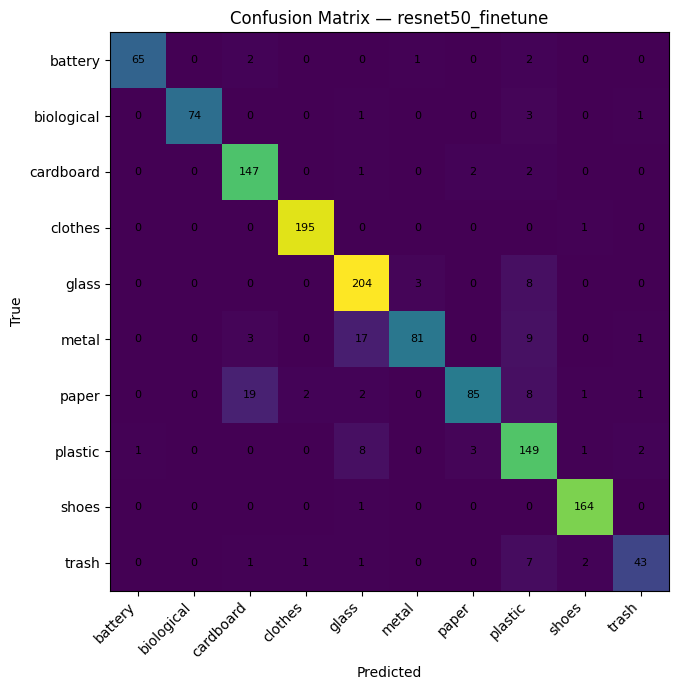

(0.29600319266319275,
 0.9086792469024658,
 0.9109433962264151,
 array([[ 65,   0,   2,   0,   0,   1,   0,   2,   0,   0],
        [  0,  74,   0,   0,   1,   0,   0,   3,   0,   1],
        [  0,   0, 147,   0,   1,   0,   2,   2,   0,   0],
        [  0,   0,   0, 195,   0,   0,   0,   0,   1,   0],
        [  0,   0,   0,   0, 204,   3,   0,   8,   0,   0],
        [  0,   0,   3,   0,  17,  81,   0,   9,   0,   1],
        [  0,   0,  19,   2,   2,   0,  85,   8,   1,   1],
        [  1,   0,   0,   0,   8,   0,   3, 149,   1,   2],
        [  0,   0,   0,   0,   1,   0,   0,   0, 164,   0],
        [  0,   0,   1,   1,   1,   0,   0,   7,   2,  43]]))

In [43]:
resnet50 = tf.keras.models.load_model(
    "resnet50_finetune.keras",
    safe_mode=False
)

evaluate_model(
    resnet50,
    test_ds,
    class_names,
    title="resnet50_finetune"
)

In [50]:
# Evaluate ResNet on all splits
train_loss, train_acc = resnet50.evaluate(train_ds, verbose=0)
val_loss, val_acc     = resnet50.evaluate(val_ds, verbose=0)
test_loss, test_acc   = resnet50.evaluate(test_ds, verbose=0)

print("Train Accuracy:", round(train_acc, 4))
print("Val Accuracy:  ", round(val_acc, 4))
print("Test Accuracy: ", round(test_acc, 4))

print("Train Loss:", round(train_loss, 4))
print("Val Loss:  ", round(val_loss, 4))
print("Test Loss: ", round(test_loss, 4))

2026-02-19 14:32:55.452719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-19 14:33:06.094495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


Train Accuracy: 0.9993
Val Accuracy:   0.9062
Test Accuracy:  0.9102
Train Loss: 0.0061
Val Loss:   0.3334
Test Loss:  0.2939


# DenseNet121

In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

train_ds = balanced_train_ds

def make_callbacks(model_name):
    return [
        keras.callbacks.ModelCheckpoint(
            filepath=f"{model_name}.keras",
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=6,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=2,
            min_lr=1e-6,
            verbose=1
        ),
    ]

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

x = layers.Rescaling(255.0)(inputs)
x = layers.Lambda(tf.keras.applications.densenet.preprocess_input)(x)

base = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=x
)

base.trainable = False

x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

densenet121 = keras.Model(inputs, outputs)

# Stage 1
densenet121.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

densenet121.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=make_callbacks("densenet121_head"),
    verbose=1
)

# Stage 2
base.trainable = True

for layer in base.layers[:-40]:
    layer.trainable = False

for layer in base.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

densenet121.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

densenet121.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=make_callbacks("densenet121_finetune"),
    verbose=1
)

test_loss, test_acc = densenet121.evaluate(test_ds, verbose=1)
print("DenseNet121 Test Accuracy:", round(test_acc, 4))

Epoch 1/15


2026-02-19 14:45:06.220952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-19 14:45:16.454122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 14:45:16.457054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


    428/Unknown - 80s 117ms/step - loss: 1.2963 - accuracy: 0.5834
Epoch 1: val_accuracy improved from -inf to 0.46205, saving model to densenet121_head.keras
428/428 [==============================] - 86s 133ms/step - loss: 1.2963 - accuracy: 0.5834 - val_loss: 1.5713 - val_accuracy: 0.4621 - lr: 3.0000e-04
Epoch 2/15


2026-02-19 14:46:25.390915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  4/428 [..............................] - ETA: 21s - loss: 1.6220 - accuracy: 0.4844

2026-02-19 14:46:35.513629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 14:46:35.517255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.9394 - accuracy: 0.6822
Epoch 2: val_accuracy improved from 0.46205 to 0.49777, saving model to densenet121_head.keras
428/428 [==============================] - 74s 123ms/step - loss: 0.9399 - accuracy: 0.6822 - val_loss: 1.5613 - val_accuracy: 0.4978 - lr: 3.0000e-04
Epoch 3/15


2026-02-19 14:47:40.154638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 22s - loss: 1.6454 - accuracy: 0.5000

2026-02-19 14:47:50.276729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 14:47:50.279726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.8262 - accuracy: 0.7242
Epoch 3: val_accuracy improved from 0.49777 to 0.50744, saving model to densenet121_head.keras
428/428 [==============================] - 74s 122ms/step - loss: 0.8262 - accuracy: 0.7242 - val_loss: 1.6344 - val_accuracy: 0.5074 - lr: 3.0000e-04
Epoch 4/15


2026-02-19 14:48:54.089841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 22s - loss: 1.5511 - accuracy: 0.4271

2026-02-19 14:49:03.378775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.7517 - accuracy: 0.7386
Epoch 4: val_accuracy improved from 0.50744 to 0.53125, saving model to densenet121_head.keras

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
428/428 [==============================] - 74s 124ms/step - loss: 0.7517 - accuracy: 0.7386 - val_loss: 1.5676 - val_accuracy: 0.5312 - lr: 3.0000e-04
Epoch 5/15


2026-02-19 14:50:08.316737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  4/428 [..............................] - ETA: 21s - loss: 1.4459 - accuracy: 0.4922

2026-02-19 14:50:18.059517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.7230 - accuracy: 0.7561
Epoch 5: val_accuracy improved from 0.53125 to 0.54464, saving model to densenet121_head.keras
428/428 [==============================] - 73s 120ms/step - loss: 0.7230 - accuracy: 0.7561 - val_loss: 1.5855 - val_accuracy: 0.5446 - lr: 1.5000e-04
Epoch 6/15


2026-02-19 14:51:21.253067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 22s - loss: 1.1011 - accuracy: 0.6667

2026-02-19 14:51:31.515561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 14:51:31.519015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.7032 - accuracy: 0.7575
Epoch 6: val_accuracy improved from 0.54464 to 0.55952, saving model to densenet121_head.keras

Epoch 6: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
428/428 [==============================] - 73s 120ms/step - loss: 0.7030 - accuracy: 0.7575 - val_loss: 1.5674 - val_accuracy: 0.5595 - lr: 1.5000e-04
Epoch 7/15


2026-02-19 14:52:33.568386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  4/428 [..............................] - ETA: 20s - loss: 1.0508 - accuracy: 0.6250

2026-02-19 14:52:42.606495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.6997 - accuracy: 0.7634
Epoch 7: val_accuracy did not improve from 0.55952
428/428 [==============================] - 71s 119ms/step - loss: 0.7005 - accuracy: 0.7631 - val_loss: 1.5436 - val_accuracy: 0.5536 - lr: 7.5000e-05
Epoch 8/15


2026-02-19 14:53:44.325396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 22s - loss: 1.0803 - accuracy: 0.6146

2026-02-19 14:53:53.992419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6682 - accuracy: 0.7739
Epoch 8: val_accuracy improved from 0.55952 to 0.56399, saving model to densenet121_head.keras
428/428 [==============================] - 72s 120ms/step - loss: 0.6682 - accuracy: 0.7739 - val_loss: 1.5274 - val_accuracy: 0.5640 - lr: 7.5000e-05
Epoch 9/15


2026-02-19 14:54:56.221267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 22s - loss: 1.0968 - accuracy: 0.6250

2026-02-19 14:55:05.436044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.7714
Epoch 9: val_accuracy did not improve from 0.56399
428/428 [==============================] - 73s 123ms/step - loss: 0.6656 - accuracy: 0.7714 - val_loss: 1.6034 - val_accuracy: 0.5565 - lr: 7.5000e-05
Epoch 10/15


2026-02-19 14:56:09.180912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 22s - loss: 0.8087 - accuracy: 0.7292

2026-02-19 14:56:17.922713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6595 - accuracy: 0.7792
Epoch 10: val_accuracy improved from 0.56399 to 0.57440, saving model to densenet121_head.keras

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
428/428 [==============================] - 73s 126ms/step - loss: 0.6595 - accuracy: 0.7792 - val_loss: 1.5633 - val_accuracy: 0.5744 - lr: 7.5000e-05
Epoch 11/15


2026-02-19 14:57:22.660398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  4/428 [..............................] - ETA: 22s - loss: 0.9658 - accuracy: 0.6250

2026-02-19 14:57:32.177524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6698 - accuracy: 0.7722
Epoch 11: val_accuracy improved from 0.57440 to 0.57961, saving model to densenet121_head.keras
428/428 [==============================] - 72s 120ms/step - loss: 0.6698 - accuracy: 0.7722 - val_loss: 1.5155 - val_accuracy: 0.5796 - lr: 3.7500e-05
Epoch 12/15


2026-02-19 14:58:34.531275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 22s - loss: 0.7808 - accuracy: 0.6979

2026-02-19 14:58:43.806163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.6496 - accuracy: 0.7789
Epoch 12: val_accuracy did not improve from 0.57961
428/428 [==============================] - 70s 117ms/step - loss: 0.6498 - accuracy: 0.7788 - val_loss: 1.5380 - val_accuracy: 0.5759 - lr: 3.7500e-05
Epoch 13/15


2026-02-19 14:59:44.623945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  4/428 [..............................] - ETA: 21s - loss: 0.8219 - accuracy: 0.7344

2026-02-19 14:59:53.455092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6496 - accuracy: 0.7769
Epoch 13: val_accuracy did not improve from 0.57961

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
428/428 [==============================] - 69s 115ms/step - loss: 0.6496 - accuracy: 0.7769 - val_loss: 1.5620 - val_accuracy: 0.5759 - lr: 3.7500e-05
Epoch 14/15


2026-02-19 15:00:53.523834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 23s - loss: 0.7967 - accuracy: 0.7083

2026-02-19 15:01:01.910271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6719 - accuracy: 0.7725
Epoch 14: val_accuracy improved from 0.57961 to 0.58631, saving model to densenet121_head.keras
428/428 [==============================] - 73s 126ms/step - loss: 0.6719 - accuracy: 0.7725 - val_loss: 1.5382 - val_accuracy: 0.5863 - lr: 1.8750e-05
Epoch 15/15


2026-02-19 15:02:06.419794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 22s - loss: 0.8823 - accuracy: 0.7083

2026-02-19 15:02:15.061350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6482 - accuracy: 0.7797
Epoch 15: val_accuracy improved from 0.58631 to 0.59152, saving model to densenet121_head.keras
428/428 [==============================] - 71s 121ms/step - loss: 0.6482 - accuracy: 0.7797 - val_loss: 1.4828 - val_accuracy: 0.5915 - lr: 1.8750e-05
Epoch 1/20


2026-02-19 15:03:27.654089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-19 15:03:38.399074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


    428/Unknown - 83s 118ms/step - loss: 0.6419 - accuracy: 0.7812
Epoch 1: val_accuracy improved from -inf to 0.58854, saving model to densenet121_finetune.keras
428/428 [==============================] - 90s 134ms/step - loss: 0.6419 - accuracy: 0.7812 - val_loss: 1.4716 - val_accuracy: 0.5885 - lr: 1.0000e-05
Epoch 2/20


2026-02-19 15:04:49.339062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 26s - loss: 0.6060 - accuracy: 0.7812

2026-02-19 15:04:59.809631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 15:04:59.813202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6425 - accuracy: 0.7827
Epoch 2: val_accuracy improved from 0.58854 to 0.59673, saving model to densenet121_finetune.keras
428/428 [==============================] - 77s 127ms/step - loss: 0.6425 - accuracy: 0.7827 - val_loss: 1.5274 - val_accuracy: 0.5967 - lr: 1.0000e-05
Epoch 3/20


2026-02-19 15:06:05.009385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 25s - loss: 0.8009 - accuracy: 0.7083

2026-02-19 15:06:15.093402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 15:06:15.096465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6337 - accuracy: 0.7822
Epoch 3: val_accuracy did not improve from 0.59673

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
428/428 [==============================] - 76s 130ms/step - loss: 0.6337 - accuracy: 0.7822 - val_loss: 1.5280 - val_accuracy: 0.5930 - lr: 1.0000e-05
Epoch 4/20


2026-02-19 15:07:21.667496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 24s - loss: 0.6721 - accuracy: 0.7396

2026-02-19 15:07:31.708339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 15:07:31.713438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6341 - accuracy: 0.7839
Epoch 4: val_accuracy did not improve from 0.59673
428/428 [==============================] - 71s 118ms/step - loss: 0.6341 - accuracy: 0.7839 - val_loss: 1.4990 - val_accuracy: 0.5915 - lr: 5.0000e-06
Epoch 5/20


2026-02-19 15:08:33.183877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 25s - loss: 0.6935 - accuracy: 0.7917

2026-02-19 15:08:42.654899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6237 - accuracy: 0.7871
Epoch 5: val_accuracy did not improve from 0.59673

Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
428/428 [==============================] - 71s 119ms/step - loss: 0.6237 - accuracy: 0.7871 - val_loss: 1.5148 - val_accuracy: 0.5923 - lr: 5.0000e-06
Epoch 6/20


2026-02-19 15:09:44.319566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 24s - loss: 0.6604 - accuracy: 0.7500

2026-02-19 15:09:53.675726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6191 - accuracy: 0.7889
Epoch 6: val_accuracy did not improve from 0.59673
428/428 [==============================] - 71s 119ms/step - loss: 0.6191 - accuracy: 0.7889 - val_loss: 1.5354 - val_accuracy: 0.5885 - lr: 2.5000e-06
Epoch 7/20


2026-02-19 15:10:55.504576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 25s - loss: 0.5776 - accuracy: 0.8125

2026-02-19 15:11:04.651467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.7882
Epoch 7: val_accuracy improved from 0.59673 to 0.59747, saving model to densenet121_finetune.keras

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.
428/428 [==============================] - 72s 123ms/step - loss: 0.6151 - accuracy: 0.7882 - val_loss: 1.4919 - val_accuracy: 0.5975 - lr: 2.5000e-06
Epoch 8/20


2026-02-19 15:12:08.084967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 24s - loss: 0.5064 - accuracy: 0.8438

2026-02-19 15:12:17.051274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6200 - accuracy: 0.7884
Epoch 8: val_accuracy did not improve from 0.59747
428/428 [==============================] - 71s 121ms/step - loss: 0.6200 - accuracy: 0.7884 - val_loss: 1.5081 - val_accuracy: 0.5960 - lr: 1.2500e-06
Epoch 9/20


2026-02-19 15:13:19.483003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 24s - loss: 0.7350 - accuracy: 0.7292

2026-02-19 15:13:28.147155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6123 - accuracy: 0.7874
Epoch 9: val_accuracy improved from 0.59747 to 0.60268, saving model to densenet121_finetune.keras

Epoch 9: ReduceLROnPlateau reducing learning rate to 1e-06.
428/428 [==============================] - 72s 123ms/step - loss: 0.6123 - accuracy: 0.7874 - val_loss: 1.5004 - val_accuracy: 0.6027 - lr: 1.2500e-06
Epoch 10/20


2026-02-19 15:14:32.409089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 23s - loss: 0.5219 - accuracy: 0.8229

2026-02-19 15:14:41.185163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6169 - accuracy: 0.7881
Epoch 10: val_accuracy did not improve from 0.60268
428/428 [==============================] - 71s 119ms/step - loss: 0.6169 - accuracy: 0.7881 - val_loss: 1.4870 - val_accuracy: 0.6004 - lr: 1.0000e-06
Epoch 11/20


2026-02-19 15:15:42.750947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 25s - loss: 0.5688 - accuracy: 0.7917

2026-02-19 15:15:52.352604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6225 - accuracy: 0.7894
Epoch 11: val_accuracy did not improve from 0.60268
428/428 [==============================] - 71s 118ms/step - loss: 0.6225 - accuracy: 0.7894 - val_loss: 1.5045 - val_accuracy: 0.5997 - lr: 1.0000e-06
Epoch 12/20


2026-02-19 15:16:53.668993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 23s - loss: 0.6410 - accuracy: 0.8125

2026-02-19 15:17:02.329334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6165 - accuracy: 0.7884
Epoch 12: val_accuracy improved from 0.60268 to 0.60863, saving model to densenet121_finetune.keras
428/428 [==============================] - 73s 125ms/step - loss: 0.6165 - accuracy: 0.7884 - val_loss: 1.4540 - val_accuracy: 0.6086 - lr: 1.0000e-06
Epoch 13/20


2026-02-19 15:18:06.541177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 25s - loss: 0.7210 - accuracy: 0.7604

2026-02-19 15:18:15.466376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6125 - accuracy: 0.7915
Epoch 13: val_accuracy did not improve from 0.60863
428/428 [==============================] - 71s 120ms/step - loss: 0.6125 - accuracy: 0.7915 - val_loss: 1.4684 - val_accuracy: 0.5997 - lr: 1.0000e-06
Epoch 14/20


2026-02-19 15:19:17.738376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 23s - loss: 0.5307 - accuracy: 0.8333

2026-02-19 15:19:27.576697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6135 - accuracy: 0.7895
Epoch 14: val_accuracy did not improve from 0.60863
428/428 [==============================] - 72s 121ms/step - loss: 0.6135 - accuracy: 0.7895 - val_loss: 1.5201 - val_accuracy: 0.5960 - lr: 1.0000e-06
Epoch 15/20


2026-02-19 15:20:30.382302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 26s - loss: 0.5912 - accuracy: 0.8021

2026-02-19 15:20:39.643502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6106 - accuracy: 0.7935
Epoch 15: val_accuracy did not improve from 0.60863
428/428 [==============================] - 72s 121ms/step - loss: 0.6106 - accuracy: 0.7935 - val_loss: 1.4962 - val_accuracy: 0.6019 - lr: 1.0000e-06
Epoch 16/20


2026-02-19 15:21:42.513767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 24s - loss: 0.5624 - accuracy: 0.7917

2026-02-19 15:21:52.347278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


427/428 [============================>.] - ETA: 0s - loss: 0.6063 - accuracy: 0.7916
Epoch 16: val_accuracy did not improve from 0.60863
428/428 [==============================] - 72s 121ms/step - loss: 0.6066 - accuracy: 0.7914 - val_loss: 1.5013 - val_accuracy: 0.5945 - lr: 1.0000e-06
Epoch 17/20


2026-02-19 15:22:55.005633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 25s - loss: 0.8050 - accuracy: 0.7500

2026-02-19 15:23:03.521309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6082 - accuracy: 0.7908
Epoch 17: val_accuracy did not improve from 0.60863
428/428 [==============================] - 71s 121ms/step - loss: 0.6082 - accuracy: 0.7908 - val_loss: 1.4823 - val_accuracy: 0.6004 - lr: 1.0000e-06
Epoch 18/20


2026-02-19 15:24:06.102925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000


  3/428 [..............................] - ETA: 23s - loss: 0.6876 - accuracy: 0.7188

2026-02-19 15:24:14.803809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


428/428 [==============================] - ETA: 0s - loss: 0.6010 - accuracy: 0.7926
Epoch 18: val_accuracy did not improve from 0.60863
Restoring model weights from the end of the best epoch: 12.
428/428 [==============================] - 71s 121ms/step - loss: 0.6010 - accuracy: 0.7926 - val_loss: 1.4739 - val_accuracy: 0.6012 - lr: 1.0000e-06
Epoch 18: early stopping
42/42 [==============================] - 2s 50ms/step - loss: 1.3939 - accuracy: 0.6075
DenseNet121 Test Accuracy: 0.6075


42/42 [==============================] - 5s 50ms/step - loss: 1.3613 - accuracy: 0.6106

densenet121 — loss: 1.3613, accuracy: 0.6106
densenet121 — accuracy_score: 0.6098

              precision    recall  f1-score   support

     battery     0.8788    0.4328    0.5800        67
  biological     0.9318    0.5395    0.6833        76
   cardboard     0.5656    0.8117    0.6667       154
     clothes     0.7733    0.8832    0.8246       197
       glass     0.5804    0.6697    0.6218       221
       metal     0.7273    0.1455    0.2424       110
       paper     0.6316    0.1062    0.1818       113
     plastic     0.4538    0.6890    0.5472       164
       shoes     0.5855    0.8155    0.6816       168
       trash     0.5652    0.2364    0.3333        55

    accuracy                         0.6098      1325
   macro avg     0.6693    0.5329    0.5363      1325
weighted avg     0.6435    0.6098    0.5760      1325



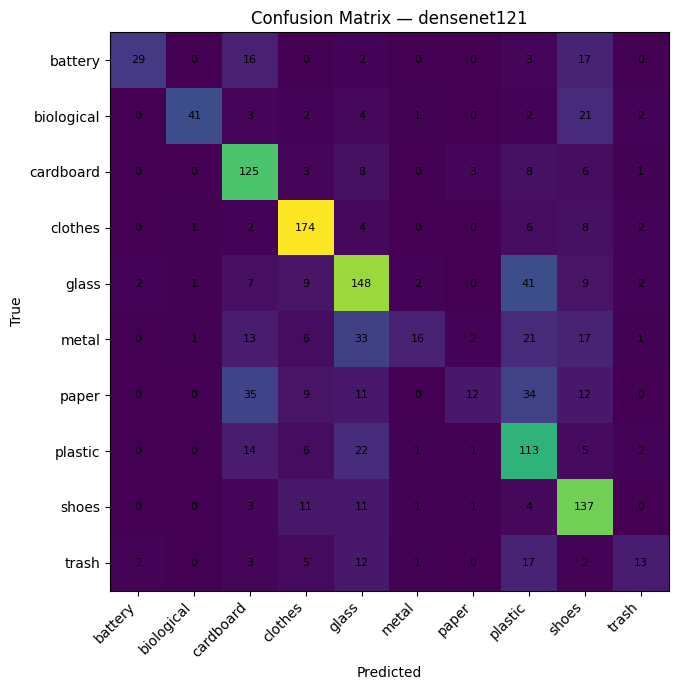

(1.361290454864502,
 0.6105660200119019,
 0.609811320754717,
 array([[ 29,   0,  16,   0,   2,   0,   0,   3,  17,   0],
        [  0,  41,   3,   2,   4,   1,   0,   2,  21,   2],
        [  0,   0, 125,   3,   8,   0,   3,   8,   6,   1],
        [  0,   1,   2, 174,   4,   0,   0,   6,   8,   2],
        [  2,   1,   7,   9, 148,   2,   0,  41,   9,   2],
        [  0,   1,  13,   6,  33,  16,   2,  21,  17,   1],
        [  0,   0,  35,   9,  11,   0,  12,  34,  12,   0],
        [  0,   0,  14,   6,  22,   1,   1, 113,   5,   2],
        [  0,   0,   3,  11,  11,   1,   1,   4, 137,   0],
        [  2,   0,   3,   5,  12,   1,   0,  17,   2,  13]]))

In [56]:
import tensorflow as tf

densenet121 = tf.keras.models.load_model(
    "densenet121_finetune.keras",
    safe_mode=False
)

evaluate_model(
    densenet121,
    test_ds,
    class_names,
    title="densenet121"
)


In [57]:
# Evaluate on all splits
train_loss, train_acc = densenet121.evaluate(train_ds, verbose=0)
val_loss, val_acc     = densenet121.evaluate(val_ds, verbose=0)
test_loss, test_acc   = densenet121.evaluate(test_ds, verbose=0)

print("Train Accuracy:", round(train_acc, 4))
print("Val Accuracy:  ", round(val_acc, 4))
print("Test Accuracy: ", round(test_acc, 4))

print("Train Loss:", round(train_loss, 4))
print("Val Loss:  ", round(val_loss, 4))
print("Test Loss: ", round(test_loss, 4))

2026-02-19 15:25:51.466078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-19 15:26:01.237201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


Train Accuracy: 0.862
Val Accuracy:   0.6019
Test Accuracy:  0.606
Train Loss: 0.4495
Val Loss:   1.4917
Test Loss:  1.3808


## Model Performance Analysis

2026-02-19 16:22:23.671403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-19 16:22:33.694529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 16:22:33.699118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2026-02-19 16:23:26.248202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 1401 of 5000
2026-02-19 16:23:36.410417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:77: Filling up shuffle buffer (this may take a while): 4035 of 5000
2026-02-19 16:23:36.412881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2026-02-19 16:24:34.018717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatas

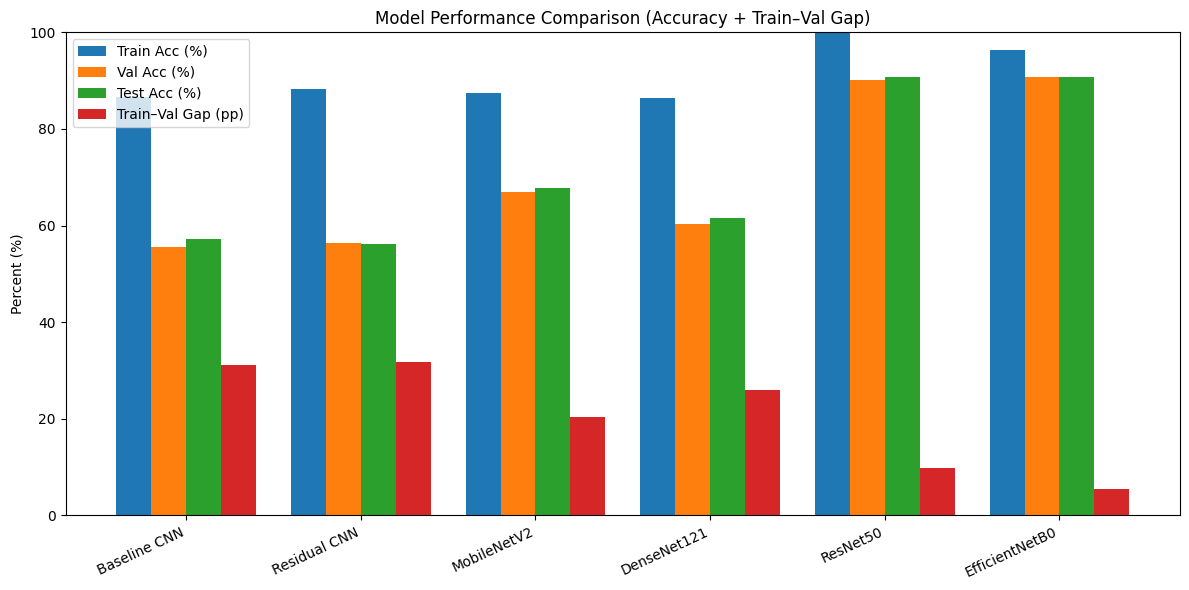

In [70]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load models
resnet50 = tf.keras.models.load_model("resnet50_finetune.keras", safe_mode=False)
efficientnetb0 = tf.keras.models.load_model("efficientnetb0_finetune.keras", safe_mode=False)
mobilenetv2 = tf.keras.models.load_model("mobilenetv2_finetune_clean.keras", safe_mode=False)
densenet121 = tf.keras.models.load_model("densenet121_finetune.keras", safe_mode=False)

baseline_cnn = tf.keras.models.load_model("baseline_exp2.keras", safe_mode=False)
residual_cnn = tf.keras.models.load_model("residual_cnn.keras", safe_mode=False)

def eval_splits(model):
    tr_loss, tr_acc = model.evaluate(train_ds, verbose=0)
    va_loss, va_acc = model.evaluate(val_ds, verbose=0)
    te_loss, te_acc = model.evaluate(test_ds, verbose=0)
    return (tr_loss, tr_acc), (va_loss, va_acc), (te_loss, te_acc)

models = {
    "Baseline CNN": baseline_cnn,
    "Residual CNN": residual_cnn,
    "MobileNetV2": mobilenetv2,
    "DenseNet121": densenet121,
    "ResNet50": resnet50,
    "EfficientNetB0": efficientnetb0,
}

results = {}
for name, model in models.items():
    (tr_loss, tr_acc), (va_loss, va_acc), (te_loss, te_acc) = eval_splits(model)
    results[name] = {
        "train": tr_acc * 100.0,
        "val": va_acc * 100.0,
        "test": te_acc * 100.0,
        "gap": (tr_acc - va_acc) * 100.0,
    }

model_names = list(results.keys())
train_vals = [results[m]["train"] for m in model_names]
val_vals   = [results[m]["val"] for m in model_names]
test_vals  = [results[m]["test"] for m in model_names]
gaps       = [results[m]["gap"] for m in model_names]

x = np.arange(len(model_names))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, train_vals, width, label="Train Acc (%)")
plt.bar(x - 0.5*width, val_vals,   width, label="Val Acc (%)")
plt.bar(x + 0.5*width, test_vals,  width, label="Test Acc (%)")
plt.bar(x + 1.5*width, gaps,       width, label="Train–Val Gap (pp)")

plt.xticks(x, model_names, rotation=25, ha="right")
plt.ylabel("Percent (%)")
plt.title("Model Performance Comparison (Accuracy + Train–Val Gap)")
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()

### Overall Accuracy Comparison

| Model            | Train Acc | Val Acc | Test Acc | Train Loss | Val Loss | Test Loss |
|------------------|-----------|---------|----------|------------|----------|-----------|
| Baseline CNN     | 0.8652    | 0.5432  | 0.5781   | 0.3974     | 1.7954   | 1.6446    |
| Residual CNN     | 0.8832    | 0.5476  | 0.5509   | 0.3152     | 2.4405   | 2.3529    |
| MobileNetV2      | 0.8871    | 0.6786  | 0.6891   | 0.3170     | 1.2923   | 1.2704    |
| DenseNet121      | 0.8620    | 0.6019  | 0.6006   | 0.4495     | 1.4917   | 1.3808    |
| ResNet50         | 0.9993    | 0.9062  | 0.9102   | 0.0061     | 0.3334   | 0.2939    |
| EfficientNetB0   | 0.9641    | 0.9062  | 0.9094   | 0.1121     | 0.2763   | 0.2688    |

---

## Interpretation

### Baseline CNN
- Simple architecture with limited depth.
- Large gap between train and validation accuracy.
- High validation loss indicates weak feature extraction.
- Struggles to capture complex visual patterns across 10 classes.

### Residual CNN
- Slightly deeper than baseline but still trained from scratch.
- Residual connections alone do not guarantee better performance.
- Dataset size likely insufficient for effective deep training.
- Higher validation loss suggests unstable learning.

### MobileNetV2
- Clear improvement over custom CNNs.
- Pretrained on ImageNet, benefiting from transfer learning.
- Moderate generalisation gap.
- Good balance between accuracy and efficiency.

### DenseNet121
- Large architecture but under-optimised.
- May require more fine-tuning or stronger regularisation.
- Validation and test accuracy lower than expected.
- Likely not fully adapted to the dataset.

### ResNet50
- Very high training accuracy.
- Strong validation and test performance (~91%).
- Small generalisation gap.
- Slight overfitting but controlled through fine-tuning.

### EfficientNetB0
- Best balance overall.
- High validation and test accuracy (~91%).
- Lower validation loss than ResNet.
- Most stable generalisation performance.

---

## Final Conclusion

- Best overall models: EfficientNetB0 and ResNet50.
- Most stable generalisation: EfficientNetB0.

### Why Baseline and Residual Underperformed

- Both models were trained from scratch without pretrained weights.
- Dataset size is relatively small compared to model complexity.
- Transfer learning models benefit from ImageNet feature representations (edges, textures, shapes).
- Custom CNNs had limited feature extraction capability.
- Residual connections help deeper networks train, but without large-scale pretraining, performance gains are limited.
- As a result, these models struggled to generalise compared to pretrained architectures.

Overall, transfer learning clearly provided a major performance advantage in this project.


# Parameter tuning

In [18]:
# ----------------------------
# Helpers (shared)
# ----------------------------
from tensorflow import keras
from tensorflow.keras import layers
import time, json, gc

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

def cb_pack(tag, patience_es=3, patience_rlr=1):
    return [
        keras.callbacks.ModelCheckpoint(
            filepath=f"{tag}.keras",
            monitor="val_accuracy",
            save_best_only=True,
            verbose=0
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=patience_es,
            restore_best_weights=True,
            verbose=0
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=patience_rlr,
            min_lr=1e-6,
            verbose=0
        ),
    ]

def cleanup():
    keras.backend.clear_session()
    gc.collect()

In [19]:
# ----------------------------
# ResNet50 (10 trials)
# ----------------------------
@keras.utils.register_keras_serializable()
class ResNet50Preprocess(layers.Layer):
    def call(self, x):
        return tf.keras.applications.resnet50.preprocess_input(x)

def build_resnet50(num_classes, img_h, img_w, dense_units, dropout, l2):
    inp = keras.Input(shape=(img_h, img_w, 3), name="image")
    x = ResNet50Preprocess(name="pre")(inp)

    base = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_tensor=x
    )
    base.trainable = False

    y = layers.GlobalAveragePooling2D(name="gap")(base.output)

    if dense_units > 0:
        reg = keras.regularizers.l2(l2) if l2 > 0 else None
        y = layers.Dense(dense_units, activation="relu", kernel_regularizer=reg, name="fc")(y)

    if dropout > 0:
        y = layers.Dropout(dropout, name="drop")(y)

    out = layers.Dense(num_classes, activation="softmax", name="pred")(y)
    model = keras.Model(inp, out, name="resnet50_search")
    return model, base

def sample_resnet_cfg():
    return {
        "dense_units": random.choice([0, 128, 256]),
        "dropout": random.choice([0.0, 0.2, 0.3, 0.4]),
        "l2": random.choice([0.0, 1e-5, 1e-4]),
        "head_lr": random.choice([7e-4, 5e-4, 3e-4]),
        "ft_lr": random.choice([5e-5, 3e-5, 1e-5]),
        "unfreeze_n": random.choice([10, 20, 30]),
        "head_epochs": random.choice([4, 5]),
        "ft_epochs": random.choice([4, 5]),
    }

def train_and_score_resnet(cfg, run_tag):
    cleanup()

    model, base = build_resnet50(
        num_classes=num_classes,
        img_h=IMG_HEIGHT,
        img_w=IMG_WIDTH,
        dense_units=cfg["dense_units"],
        dropout=cfg["dropout"],
        l2=cfg["l2"],
    )

    loss_fn = keras.losses.SparseCategoricalCrossentropy()

    model.compile(
        optimizer=keras.optimizers.Adam(cfg["head_lr"]),
        loss=loss_fn,
        metrics=["accuracy"]
    )
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=cfg["head_epochs"],
        callbacks=cb_pack(run_tag + "_head", patience_es=2, patience_rlr=1),
        verbose=2
    )

    base.trainable = True
    for layer in base.layers[:-cfg["unfreeze_n"]]:
        layer.trainable = False
    for layer in base.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False

    model.compile(
        optimizer=keras.optimizers.Adam(cfg["ft_lr"]),
        loss=loss_fn,
        metrics=["accuracy"]
    )
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=cfg["ft_epochs"],
        callbacks=cb_pack(run_tag + "_ft", patience_es=2, patience_rlr=1),
        verbose=2
    )

    best_path = run_tag + "_ft.keras"
    best_model = tf.keras.models.load_model(best_path, safe_mode=False)

    v_loss, v_acc = best_model.evaluate(val_ds, verbose=0)
    t_loss, t_acc = best_model.evaluate(test_ds, verbose=0)
    return float(v_acc), float(t_acc), float(v_loss), float(t_loss), best_path

def random_search_resnet(trials=10, out_prefix="resnet50_best"):
    best = {"val_acc": -1.0}
    log_rows = []

    for i in range(trials):
        cfg = sample_resnet_cfg()
        tag = f"rs50_trial{i+1:02d}"
        print(f"\nResNet50 trial {i+1}/{trials} | cfg: {cfg}")
        t0 = time.time()

        try:
            v_acc, t_acc, v_loss, t_loss, ckpt = train_and_score_resnet(cfg, tag)
            dt = time.time() - t0
            row = {
                "trial": i + 1,
                "status": "ok",
                "val_acc": v_acc,
                "test_acc": t_acc,
                "val_loss": v_loss,
                "test_loss": t_loss,
                "ckpt": ckpt,
                "sec": round(dt, 1),
                **cfg
            }
            log_rows.append(row)
            if v_acc > best["val_acc"]:
                best = row.copy()
        except Exception as e:
            print(f"ResNet50 trial {i+1} failed:", repr(e))
            log_rows.append({"trial": i + 1, "status": "fail", "error": str(e), **cfg})

    with open(out_prefix + "_search_log.json", "w") as f:
        json.dump(log_rows, f, indent=2)

    if best["val_acc"] < 0:
        raise RuntimeError("No successful ResNet50 trial completed.")

    best_model = tf.keras.models.load_model(best["ckpt"], safe_mode=False)
    best_model.save(out_prefix + ".keras")

    with open(out_prefix + "_best_cfg.json", "w") as f:
        json.dump(best, f, indent=2)

    print(f"\nResNet50 best | val_acc={best['val_acc']:.4f} test_acc={best['test_acc']:.4f}")
    print("Saved:", out_prefix + ".keras")
    return best

best_resnet = random_search_resnet(trials=10, out_prefix="resnet50_best")

resnet_best = tf.keras.models.load_model("resnet50_best.keras", safe_mode=False)
tr_loss, tr_acc = resnet_best.evaluate(train_ds, verbose=0)
va_loss, va_acc = resnet_best.evaluate(val_ds, verbose=0)
te_loss, te_acc = resnet_best.evaluate(test_ds, verbose=0)
print("[ResNet50 best] acc:", round(tr_acc, 4), round(va_acc, 4), round(te_acc, 4))
print("[ResNet50 best] loss:", round(tr_loss, 4), round(va_loss, 4), round(te_loss, 4))


ResNet50 trial 1/10 | cfg: {'dense_units': 256, 'dropout': 0.0, 'l2': 0.0, 'head_lr': 0.0003, 'ft_lr': 3e-05, 'unfreeze_n': 10, 'head_epochs': 4, 'ft_epochs': 4}
Epoch 1/4
334/334 - 24s - loss: 0.4096 - accuracy: 0.8673 - val_loss: 0.2762 - val_accuracy: 0.9062 - lr: 3.0000e-04 - 24s/epoch - 71ms/step
Epoch 2/4
334/334 - 19s - loss: 0.1892 - accuracy: 0.9388 - val_loss: 0.2120 - val_accuracy: 0.9308 - lr: 3.0000e-04 - 19s/epoch - 56ms/step
Epoch 3/4
334/334 - 19s - loss: 0.1172 - accuracy: 0.9633 - val_loss: 0.1912 - val_accuracy: 0.9368 - lr: 3.0000e-04 - 19s/epoch - 56ms/step
Epoch 4/4
334/334 - 19s - loss: 0.0737 - accuracy: 0.9776 - val_loss: 0.1808 - val_accuracy: 0.9405 - lr: 3.0000e-04 - 19s/epoch - 57ms/step
Epoch 1/4
334/334 - 25s - loss: 0.0479 - accuracy: 0.9871 - val_loss: 0.1620 - val_accuracy: 0.9449 - lr: 3.0000e-05 - 25s/epoch - 76ms/step
Epoch 2/4
334/334 - 19s - loss: 0.0135 - accuracy: 0.9989 - val_loss: 0.1840 - val_accuracy: 0.9435 - lr: 3.0000e-05 - 19s/epoch - 5

42/42 [==============================] - 2s 46ms/step - loss: 0.1736 - accuracy: 0.9555

ResNet50 (Tuned) — loss: 0.1736, accuracy: 0.9555
ResNet50 (Tuned) — accuracy_score: 0.9555

              precision    recall  f1-score   support

     battery     0.9861    0.9726    0.9793        73
  biological     0.9867    0.9737    0.9801        76
   cardboard     0.9781    0.9371    0.9571       143
     clothes     0.9948    0.9948    0.9948       194
       glass     0.9339    0.9725    0.9528       218
       metal     0.9196    0.9279    0.9238       111
       paper     0.9167    0.9402    0.9283       117
     plastic     0.9430    0.8922    0.9169       167
       shoes     0.9718    0.9942    0.9829       173
       trash     0.9057    0.9057    0.9057        53

    accuracy                         0.9555      1325
   macro avg     0.9536    0.9511    0.9522      1325
weighted avg     0.9557    0.9555    0.9554      1325



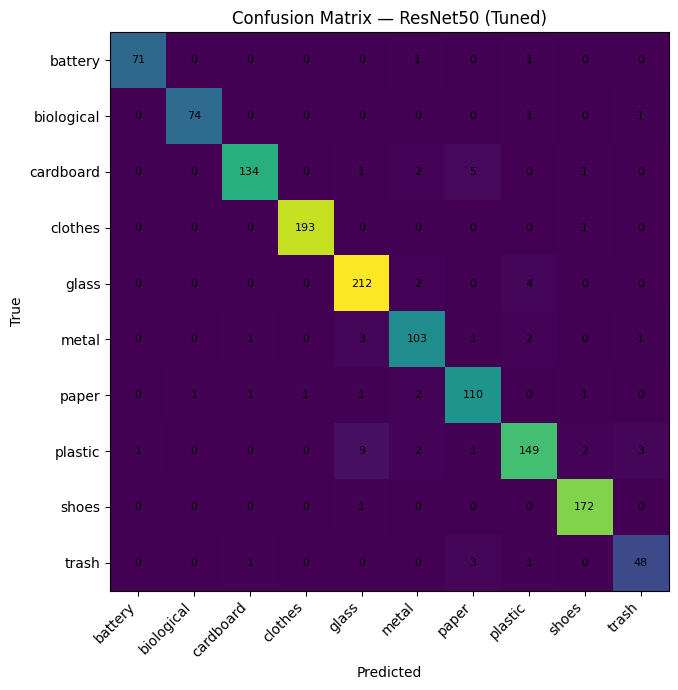

(0.17357739806175232,
 0.9554716944694519,
 0.9554716981132075,
 array([[ 71,   0,   0,   0,   0,   1,   0,   1,   0,   0],
        [  0,  74,   0,   0,   0,   0,   0,   1,   0,   1],
        [  0,   0, 134,   0,   1,   2,   5,   0,   1,   0],
        [  0,   0,   0, 193,   0,   0,   0,   0,   1,   0],
        [  0,   0,   0,   0, 212,   2,   0,   4,   0,   0],
        [  0,   0,   1,   0,   3, 103,   1,   2,   0,   1],
        [  0,   1,   1,   1,   1,   2, 110,   0,   1,   0],
        [  1,   0,   0,   0,   9,   2,   1, 149,   2,   3],
        [  0,   0,   0,   0,   1,   0,   0,   0, 172,   0],
        [  0,   0,   1,   0,   0,   0,   3,   1,   0,  48]]))

In [21]:
evaluate_model(resnet_best, test_ds, class_names, title="ResNet50 (Tuned)")

In [20]:
# ----------------------------
# EfficientNetB0 (10 trials)
# ----------------------------
@keras.utils.register_keras_serializable()
class EffB0Pre(layers.Layer):
    def call(self, x):
        return tf.keras.applications.efficientnet.preprocess_input(x)

def build_effb0(num_classes, img_h, img_w, dropout, head_dense, l2):
    inp = keras.Input(shape=(img_h, img_w, 3), name="image")
    x = EffB0Pre(name="pre")(inp)

    base = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_tensor=x
    )
    base.trainable = False

    y = layers.GlobalAveragePooling2D(name="gap")(base.output)

    if head_dense > 0:
        reg = keras.regularizers.l2(l2) if l2 > 0 else None
        y = layers.Dense(head_dense, activation="relu", kernel_regularizer=reg, name="fc")(y)

    if dropout > 0:
        y = layers.Dropout(dropout, name="drop")(y)

    out = layers.Dense(num_classes, activation="softmax", name="pred")(y)
    model = keras.Model(inp, out, name="effb0_search")
    return model, base

def sample_eff_cfg():
    return {
        "dropout": random.choice([0.0, 0.2, 0.35]),
        "head_dense": random.choice([0, 128, 256]),
        "l2": random.choice([0.0, 1e-5, 1e-4]),
        "head_lr": random.choice([7e-4, 5e-4, 3e-4]),
        "ft_lr": random.choice([3e-5, 1e-5, 5e-6]),
        "unfreeze_n": random.choice([10, 20, 30]),
        "head_epochs": random.choice([4, 5]),
        "ft_epochs": random.choice([4, 5]),
    }

def train_and_score_eff(cfg, run_tag):
    cleanup()

    model, base = build_effb0(
        num_classes=num_classes,
        img_h=IMG_HEIGHT,
        img_w=IMG_WIDTH,
        dropout=cfg["dropout"],
        head_dense=cfg["head_dense"],
        l2=cfg["l2"],
    )

    loss_fn = keras.losses.SparseCategoricalCrossentropy()

    model.compile(
        optimizer=keras.optimizers.Adam(cfg["head_lr"]),
        loss=loss_fn,
        metrics=["accuracy"]
    )
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=cfg["head_epochs"],
        callbacks=cb_pack(run_tag + "_head", patience_es=2, patience_rlr=1),
        verbose=2
    )

    base.trainable = True
    for layer in base.layers[:-cfg["unfreeze_n"]]:
        layer.trainable = False
    for layer in base.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False

    model.compile(
        optimizer=keras.optimizers.Adam(cfg["ft_lr"]),
        loss=loss_fn,
        metrics=["accuracy"]
    )
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=cfg["ft_epochs"],
        callbacks=cb_pack(run_tag + "_ft", patience_es=2, patience_rlr=1),
        verbose=2
    )

    best_path = run_tag + "_ft.keras"
    best_model = tf.keras.models.load_model(best_path, safe_mode=False)

    v_loss, v_acc = best_model.evaluate(val_ds, verbose=0)
    t_loss, t_acc = best_model.evaluate(test_ds, verbose=0)
    return float(v_acc), float(t_acc), float(v_loss), float(t_loss), best_path

def random_search_effb0(trials=10, out_prefix="efficientnetb0_best"):
    best = {"val_acc": -1.0}
    log_rows = []

    for i in range(trials):
        cfg = sample_eff_cfg()
        tag = f"eff_trial{i+1:02d}"
        print(f"\nEffB0 trial {i+1}/{trials} | cfg: {cfg}")
        t0 = time.time()

        try:
            v_acc, t_acc, v_loss, t_loss, ckpt = train_and_score_eff(cfg, tag)
            dt = time.time() - t0
            row = {
                "trial": i + 1,
                "status": "ok",
                "val_acc": v_acc,
                "test_acc": t_acc,
                "val_loss": v_loss,
                "test_loss": t_loss,
                "ckpt": ckpt,
                "sec": round(dt, 1),
                **cfg
            }
            log_rows.append(row)
            if v_acc > best["val_acc"]:
                best = row.copy()
        except Exception as e:
            print(f"EffB0 trial {i+1} failed:", repr(e))
            log_rows.append({"trial": i + 1, "status": "fail", "error": str(e), **cfg})

    with open(out_prefix + "_search_log.json", "w") as f:
        json.dump(log_rows, f, indent=2)

    if best["val_acc"] < 0:
        raise RuntimeError("No successful EfficientNetB0 trial completed.")

    best_model = tf.keras.models.load_model(best["ckpt"], safe_mode=False)
    best_model.save(out_prefix + ".keras")

    with open(out_prefix + "_best_cfg.json", "w") as f:
        json.dump(best, f, indent=2)

    print(f"\nEffB0 best | val_acc={best['val_acc']:.4f} test_acc={best['test_acc']:.4f}")
    print("Saved:", out_prefix + ".keras")
    return best

best_eff = random_search_effb0(trials=10, out_prefix="efficientnetb0_best")

eff_best = tf.keras.models.load_model("efficientnetb0_best.keras", safe_mode=False)
tr_loss, tr_acc = eff_best.evaluate(train_ds, verbose=0)
va_loss, va_acc = eff_best.evaluate(val_ds, verbose=0)
te_loss, te_acc = eff_best.evaluate(test_ds, verbose=0)
print("[EffB0 best] acc:", round(tr_acc, 4), round(va_acc, 4), round(te_acc, 4))
print("[EffB0 best] loss:", round(tr_loss, 4), round(va_loss, 4), round(te_loss, 4))


EffB0 trial 1/10 | cfg: {'dropout': 0.35, 'head_dense': 256, 'l2': 1e-05, 'head_lr': 0.0005, 'ft_lr': 3e-05, 'unfreeze_n': 20, 'head_epochs': 5, 'ft_epochs': 5}
Epoch 1/5


2026-02-19 20:17:17.157621: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 25s - loss: 0.4489 - accuracy: 0.8615 - val_loss: 0.2538 - val_accuracy: 0.9137 - lr: 5.0000e-04 - 25s/epoch - 74ms/step
Epoch 2/5
334/334 - 15s - loss: 0.2179 - accuracy: 0.9285 - val_loss: 0.2129 - val_accuracy: 0.9271 - lr: 5.0000e-04 - 15s/epoch - 44ms/step
Epoch 3/5
334/334 - 14s - loss: 0.1597 - accuracy: 0.9506 - val_loss: 0.1908 - val_accuracy: 0.9397 - lr: 5.0000e-04 - 14s/epoch - 43ms/step
Epoch 4/5
334/334 - 14s - loss: 0.1234 - accuracy: 0.9629 - val_loss: 0.1763 - val_accuracy: 0.9457 - lr: 5.0000e-04 - 14s/epoch - 43ms/step
Epoch 5/5
334/334 - 14s - loss: 0.1018 - accuracy: 0.9706 - val_loss: 0.1733 - val_accuracy: 0.9427 - lr: 5.0000e-04 - 14s/epoch - 41ms/step
Epoch 1/5


2026-02-19 20:18:39.382155: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 25s - loss: 0.0749 - accuracy: 0.9798 - val_loss: 0.1683 - val_accuracy: 0.9464 - lr: 3.0000e-05 - 25s/epoch - 76ms/step
Epoch 2/5
334/334 - 15s - loss: 0.0604 - accuracy: 0.9838 - val_loss: 0.1705 - val_accuracy: 0.9449 - lr: 3.0000e-05 - 15s/epoch - 45ms/step
Epoch 3/5
334/334 - 15s - loss: 0.0454 - accuracy: 0.9906 - val_loss: 0.1713 - val_accuracy: 0.9449 - lr: 1.5000e-05 - 15s/epoch - 45ms/step

EffB0 trial 2/10 | cfg: {'dropout': 0.35, 'head_dense': 256, 'l2': 1e-05, 'head_lr': 0.0007, 'ft_lr': 1e-05, 'unfreeze_n': 30, 'head_epochs': 5, 'ft_epochs': 5}
Epoch 1/5


2026-02-19 20:19:52.416233: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 22s - loss: 0.4170 - accuracy: 0.8694 - val_loss: 0.2428 - val_accuracy: 0.9189 - lr: 7.0000e-04 - 22s/epoch - 67ms/step
Epoch 2/5
334/334 - 15s - loss: 0.2000 - accuracy: 0.9360 - val_loss: 0.1994 - val_accuracy: 0.9338 - lr: 7.0000e-04 - 15s/epoch - 44ms/step
Epoch 3/5
334/334 - 14s - loss: 0.1410 - accuracy: 0.9561 - val_loss: 0.1872 - val_accuracy: 0.9412 - lr: 7.0000e-04 - 14s/epoch - 43ms/step
Epoch 4/5
334/334 - 14s - loss: 0.1086 - accuracy: 0.9675 - val_loss: 0.1758 - val_accuracy: 0.9375 - lr: 7.0000e-04 - 14s/epoch - 41ms/step
Epoch 5/5
334/334 - 14s - loss: 0.0892 - accuracy: 0.9721 - val_loss: 0.1886 - val_accuracy: 0.9405 - lr: 7.0000e-04 - 14s/epoch - 41ms/step
Epoch 1/5


2026-02-19 20:21:11.754265: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 26s - loss: 0.0920 - accuracy: 0.9740 - val_loss: 0.1897 - val_accuracy: 0.9397 - lr: 1.0000e-05 - 26s/epoch - 78ms/step
Epoch 2/5
334/334 - 16s - loss: 0.0827 - accuracy: 0.9776 - val_loss: 0.1634 - val_accuracy: 0.9472 - lr: 1.0000e-05 - 16s/epoch - 49ms/step
Epoch 3/5
334/334 - 15s - loss: 0.0771 - accuracy: 0.9789 - val_loss: 0.1753 - val_accuracy: 0.9427 - lr: 1.0000e-05 - 15s/epoch - 46ms/step
Epoch 4/5
334/334 - 16s - loss: 0.0707 - accuracy: 0.9815 - val_loss: 0.1646 - val_accuracy: 0.9464 - lr: 5.0000e-06 - 16s/epoch - 47ms/step

EffB0 trial 3/10 | cfg: {'dropout': 0.35, 'head_dense': 128, 'l2': 0.0001, 'head_lr': 0.0005, 'ft_lr': 5e-06, 'unfreeze_n': 20, 'head_epochs': 4, 'ft_epochs': 5}
Epoch 1/4


2026-02-19 20:22:41.629565: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 22s - loss: 0.5573 - accuracy: 0.8407 - val_loss: 0.2901 - val_accuracy: 0.9122 - lr: 5.0000e-04 - 22s/epoch - 66ms/step
Epoch 2/4
334/334 - 14s - loss: 0.2751 - accuracy: 0.9199 - val_loss: 0.2466 - val_accuracy: 0.9301 - lr: 5.0000e-04 - 14s/epoch - 43ms/step
Epoch 3/4
334/334 - 13s - loss: 0.2173 - accuracy: 0.9415 - val_loss: 0.2283 - val_accuracy: 0.9301 - lr: 5.0000e-04 - 13s/epoch - 40ms/step
Epoch 4/4
334/334 - 14s - loss: 0.1873 - accuracy: 0.9487 - val_loss: 0.2107 - val_accuracy: 0.9368 - lr: 5.0000e-04 - 14s/epoch - 43ms/step
Epoch 1/5


2026-02-19 20:23:46.611305: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 25s - loss: 0.1501 - accuracy: 0.9639 - val_loss: 0.2144 - val_accuracy: 0.9345 - lr: 5.0000e-06 - 25s/epoch - 74ms/step
Epoch 2/5
334/334 - 16s - loss: 0.1466 - accuracy: 0.9638 - val_loss: 0.2174 - val_accuracy: 0.9390 - lr: 5.0000e-06 - 16s/epoch - 47ms/step
Epoch 3/5
334/334 - 14s - loss: 0.1405 - accuracy: 0.9638 - val_loss: 0.2059 - val_accuracy: 0.9390 - lr: 2.5000e-06 - 14s/epoch - 43ms/step
Epoch 4/5
334/334 - 16s - loss: 0.1374 - accuracy: 0.9673 - val_loss: 0.2024 - val_accuracy: 0.9420 - lr: 2.5000e-06 - 16s/epoch - 47ms/step
Epoch 5/5
334/334 - 16s - loss: 0.1365 - accuracy: 0.9656 - val_loss: 0.1990 - val_accuracy: 0.9435 - lr: 2.5000e-06 - 16s/epoch - 47ms/step

EffB0 trial 4/10 | cfg: {'dropout': 0.0, 'head_dense': 256, 'l2': 1e-05, 'head_lr': 0.0007, 'ft_lr': 1e-05, 'unfreeze_n': 20, 'head_epochs': 4, 'ft_epochs': 5}
Epoch 1/4


2026-02-19 20:25:29.107914: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 23s - loss: 0.3590 - accuracy: 0.8869 - val_loss: 0.2339 - val_accuracy: 0.9234 - lr: 7.0000e-04 - 23s/epoch - 68ms/step
Epoch 2/4
334/334 - 15s - loss: 0.1532 - accuracy: 0.9531 - val_loss: 0.1945 - val_accuracy: 0.9360 - lr: 7.0000e-04 - 15s/epoch - 43ms/step
Epoch 3/4
334/334 - 14s - loss: 0.1011 - accuracy: 0.9711 - val_loss: 0.1873 - val_accuracy: 0.9375 - lr: 7.0000e-04 - 14s/epoch - 43ms/step
Epoch 4/4
334/334 - 14s - loss: 0.0693 - accuracy: 0.9818 - val_loss: 0.1808 - val_accuracy: 0.9390 - lr: 7.0000e-04 - 14s/epoch - 42ms/step
Epoch 1/5


2026-02-19 20:26:35.237900: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 25s - loss: 0.0375 - accuracy: 0.9934 - val_loss: 0.1828 - val_accuracy: 0.9405 - lr: 1.0000e-05 - 25s/epoch - 74ms/step
Epoch 2/5
334/334 - 16s - loss: 0.0307 - accuracy: 0.9951 - val_loss: 0.1900 - val_accuracy: 0.9412 - lr: 1.0000e-05 - 16s/epoch - 47ms/step
Epoch 3/5
334/334 - 16s - loss: 0.0267 - accuracy: 0.9961 - val_loss: 0.1832 - val_accuracy: 0.9420 - lr: 5.0000e-06 - 16s/epoch - 48ms/step
Epoch 4/5
334/334 - 16s - loss: 0.0244 - accuracy: 0.9964 - val_loss: 0.1834 - val_accuracy: 0.9435 - lr: 2.5000e-06 - 16s/epoch - 47ms/step
Epoch 5/5
334/334 - 15s - loss: 0.0241 - accuracy: 0.9963 - val_loss: 0.1816 - val_accuracy: 0.9405 - lr: 1.2500e-06 - 15s/epoch - 44ms/step

EffB0 trial 5/10 | cfg: {'dropout': 0.35, 'head_dense': 128, 'l2': 0.0, 'head_lr': 0.0007, 'ft_lr': 3e-05, 'unfreeze_n': 10, 'head_epochs': 5, 'ft_epochs': 4}
Epoch 1/5


2026-02-19 20:28:18.845989: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 22s - loss: 0.4723 - accuracy: 0.8550 - val_loss: 0.2369 - val_accuracy: 0.9234 - lr: 7.0000e-04 - 22s/epoch - 67ms/step
Epoch 2/5
334/334 - 15s - loss: 0.2265 - accuracy: 0.9285 - val_loss: 0.2043 - val_accuracy: 0.9323 - lr: 7.0000e-04 - 15s/epoch - 44ms/step
Epoch 3/5
334/334 - 15s - loss: 0.1702 - accuracy: 0.9451 - val_loss: 0.1802 - val_accuracy: 0.9338 - lr: 7.0000e-04 - 15s/epoch - 44ms/step
Epoch 4/5
334/334 - 14s - loss: 0.1343 - accuracy: 0.9563 - val_loss: 0.1712 - val_accuracy: 0.9397 - lr: 7.0000e-04 - 14s/epoch - 43ms/step
Epoch 5/5
334/334 - 14s - loss: 0.1095 - accuracy: 0.9660 - val_loss: 0.1735 - val_accuracy: 0.9368 - lr: 7.0000e-04 - 14s/epoch - 40ms/step
Epoch 1/4


2026-02-19 20:29:38.875942: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 24s - loss: 0.0859 - accuracy: 0.9730 - val_loss: 0.1710 - val_accuracy: 0.9375 - lr: 3.0000e-05 - 24s/epoch - 72ms/step
Epoch 2/4
334/334 - 15s - loss: 0.0706 - accuracy: 0.9781 - val_loss: 0.1685 - val_accuracy: 0.9435 - lr: 3.0000e-05 - 15s/epoch - 45ms/step
Epoch 3/4
334/334 - 15s - loss: 0.0597 - accuracy: 0.9825 - val_loss: 0.1556 - val_accuracy: 0.9442 - lr: 3.0000e-05 - 15s/epoch - 45ms/step
Epoch 4/4
334/334 - 14s - loss: 0.0538 - accuracy: 0.9836 - val_loss: 0.1577 - val_accuracy: 0.9405 - lr: 3.0000e-05 - 14s/epoch - 42ms/step

EffB0 trial 6/10 | cfg: {'dropout': 0.2, 'head_dense': 0, 'l2': 1e-05, 'head_lr': 0.0003, 'ft_lr': 3e-05, 'unfreeze_n': 20, 'head_epochs': 4, 'ft_epochs': 5}
Epoch 1/4


2026-02-19 20:31:02.623233: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 22s - loss: 0.9561 - accuracy: 0.7496 - val_loss: 0.5118 - val_accuracy: 0.8720 - lr: 3.0000e-04 - 22s/epoch - 66ms/step
Epoch 2/4
334/334 - 14s - loss: 0.4253 - accuracy: 0.8853 - val_loss: 0.3747 - val_accuracy: 0.8869 - lr: 3.0000e-04 - 14s/epoch - 43ms/step
Epoch 3/4
334/334 - 14s - loss: 0.3358 - accuracy: 0.9040 - val_loss: 0.3241 - val_accuracy: 0.8966 - lr: 3.0000e-04 - 14s/epoch - 43ms/step
Epoch 4/4
334/334 - 14s - loss: 0.2897 - accuracy: 0.9112 - val_loss: 0.3018 - val_accuracy: 0.9070 - lr: 3.0000e-04 - 14s/epoch - 43ms/step
Epoch 1/5


2026-02-19 20:32:08.108614: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 24s - loss: 0.2425 - accuracy: 0.9206 - val_loss: 0.2429 - val_accuracy: 0.9159 - lr: 3.0000e-05 - 24s/epoch - 73ms/step
Epoch 2/5
334/334 - 16s - loss: 0.1991 - accuracy: 0.9339 - val_loss: 0.2215 - val_accuracy: 0.9271 - lr: 3.0000e-05 - 16s/epoch - 47ms/step
Epoch 3/5
334/334 - 16s - loss: 0.1704 - accuracy: 0.9440 - val_loss: 0.2010 - val_accuracy: 0.9293 - lr: 3.0000e-05 - 16s/epoch - 47ms/step
Epoch 4/5
334/334 - 16s - loss: 0.1466 - accuracy: 0.9526 - val_loss: 0.1836 - val_accuracy: 0.9345 - lr: 3.0000e-05 - 16s/epoch - 47ms/step
Epoch 5/5
334/334 - 15s - loss: 0.1262 - accuracy: 0.9605 - val_loss: 0.1823 - val_accuracy: 0.9330 - lr: 3.0000e-05 - 15s/epoch - 44ms/step

EffB0 trial 7/10 | cfg: {'dropout': 0.2, 'head_dense': 128, 'l2': 1e-05, 'head_lr': 0.0005, 'ft_lr': 5e-06, 'unfreeze_n': 30, 'head_epochs': 4, 'ft_epochs': 5}
Epoch 1/4


2026-02-19 20:33:49.851036: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 22s - loss: 0.4846 - accuracy: 0.8577 - val_loss: 0.2546 - val_accuracy: 0.9174 - lr: 5.0000e-04 - 22s/epoch - 66ms/step
Epoch 2/4
334/334 - 15s - loss: 0.2272 - accuracy: 0.9272 - val_loss: 0.2079 - val_accuracy: 0.9338 - lr: 5.0000e-04 - 15s/epoch - 44ms/step
Epoch 3/4
334/334 - 15s - loss: 0.1664 - accuracy: 0.9498 - val_loss: 0.1912 - val_accuracy: 0.9382 - lr: 5.0000e-04 - 15s/epoch - 44ms/step
Epoch 4/4
334/334 - 15s - loss: 0.1383 - accuracy: 0.9570 - val_loss: 0.1793 - val_accuracy: 0.9397 - lr: 5.0000e-04 - 15s/epoch - 44ms/step
Epoch 1/5


2026-02-19 20:34:56.390156: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 26s - loss: 0.1001 - accuracy: 0.9724 - val_loss: 0.1726 - val_accuracy: 0.9412 - lr: 5.0000e-06 - 26s/epoch - 77ms/step
Epoch 2/5
334/334 - 15s - loss: 0.0904 - accuracy: 0.9735 - val_loss: 0.1782 - val_accuracy: 0.9382 - lr: 5.0000e-06 - 15s/epoch - 45ms/step
Epoch 3/5
334/334 - 15s - loss: 0.0873 - accuracy: 0.9744 - val_loss: 0.1720 - val_accuracy: 0.9397 - lr: 2.5000e-06 - 15s/epoch - 46ms/step

EffB0 trial 8/10 | cfg: {'dropout': 0.2, 'head_dense': 128, 'l2': 0.0, 'head_lr': 0.0005, 'ft_lr': 3e-05, 'unfreeze_n': 20, 'head_epochs': 5, 'ft_epochs': 4}
Epoch 1/5


2026-02-19 20:36:09.543599: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 22s - loss: 0.4866 - accuracy: 0.8543 - val_loss: 0.2532 - val_accuracy: 0.9115 - lr: 5.0000e-04 - 22s/epoch - 67ms/step
Epoch 2/5
334/334 - 14s - loss: 0.2196 - accuracy: 0.9289 - val_loss: 0.2062 - val_accuracy: 0.9286 - lr: 5.0000e-04 - 14s/epoch - 43ms/step
Epoch 3/5
334/334 - 14s - loss: 0.1597 - accuracy: 0.9505 - val_loss: 0.1924 - val_accuracy: 0.9345 - lr: 5.0000e-04 - 14s/epoch - 43ms/step
Epoch 4/5
334/334 - 14s - loss: 0.1332 - accuracy: 0.9563 - val_loss: 0.1831 - val_accuracy: 0.9412 - lr: 5.0000e-04 - 14s/epoch - 42ms/step
Epoch 5/5
334/334 - 13s - loss: 0.1045 - accuracy: 0.9689 - val_loss: 0.1751 - val_accuracy: 0.9397 - lr: 5.0000e-04 - 13s/epoch - 40ms/step
Epoch 1/4


2026-02-19 20:37:28.799893: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 24s - loss: 0.0772 - accuracy: 0.9777 - val_loss: 0.1641 - val_accuracy: 0.9449 - lr: 3.0000e-05 - 24s/epoch - 73ms/step
Epoch 2/4
334/334 - 15s - loss: 0.0591 - accuracy: 0.9816 - val_loss: 0.1564 - val_accuracy: 0.9501 - lr: 3.0000e-05 - 15s/epoch - 45ms/step
Epoch 3/4
334/334 - 14s - loss: 0.0499 - accuracy: 0.9854 - val_loss: 0.1623 - val_accuracy: 0.9464 - lr: 3.0000e-05 - 14s/epoch - 43ms/step
Epoch 4/4
334/334 - 15s - loss: 0.0404 - accuracy: 0.9888 - val_loss: 0.1689 - val_accuracy: 0.9464 - lr: 1.5000e-05 - 15s/epoch - 44ms/step

EffB0 trial 9/10 | cfg: {'dropout': 0.2, 'head_dense': 128, 'l2': 1e-05, 'head_lr': 0.0003, 'ft_lr': 1e-05, 'unfreeze_n': 20, 'head_epochs': 5, 'ft_epochs': 4}
Epoch 1/5


2026-02-19 20:38:53.901370: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 22s - loss: 0.5820 - accuracy: 0.8300 - val_loss: 0.2896 - val_accuracy: 0.9040 - lr: 3.0000e-04 - 22s/epoch - 66ms/step
Epoch 2/5
334/334 - 14s - loss: 0.2585 - accuracy: 0.9167 - val_loss: 0.2605 - val_accuracy: 0.9115 - lr: 3.0000e-04 - 14s/epoch - 43ms/step
Epoch 3/5
334/334 - 14s - loss: 0.2030 - accuracy: 0.9347 - val_loss: 0.2213 - val_accuracy: 0.9256 - lr: 3.0000e-04 - 14s/epoch - 42ms/step
Epoch 4/5
334/334 - 14s - loss: 0.1653 - accuracy: 0.9497 - val_loss: 0.2049 - val_accuracy: 0.9301 - lr: 3.0000e-04 - 14s/epoch - 43ms/step
Epoch 5/5
334/334 - 14s - loss: 0.1453 - accuracy: 0.9569 - val_loss: 0.1991 - val_accuracy: 0.9338 - lr: 3.0000e-04 - 14s/epoch - 43ms/step
Epoch 1/4


2026-02-19 20:40:13.371513: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 24s - loss: 0.1125 - accuracy: 0.9668 - val_loss: 0.1910 - val_accuracy: 0.9360 - lr: 1.0000e-05 - 24s/epoch - 73ms/step
Epoch 2/4
334/334 - 15s - loss: 0.1013 - accuracy: 0.9698 - val_loss: 0.1796 - val_accuracy: 0.9390 - lr: 1.0000e-05 - 15s/epoch - 46ms/step
Epoch 3/4
334/334 - 14s - loss: 0.0943 - accuracy: 0.9723 - val_loss: 0.1812 - val_accuracy: 0.9353 - lr: 1.0000e-05 - 14s/epoch - 43ms/step
Epoch 4/4
334/334 - 14s - loss: 0.0864 - accuracy: 0.9756 - val_loss: 0.1869 - val_accuracy: 0.9390 - lr: 5.0000e-06 - 14s/epoch - 43ms/step

EffB0 trial 10/10 | cfg: {'dropout': 0.0, 'head_dense': 0, 'l2': 1e-05, 'head_lr': 0.0005, 'ft_lr': 5e-06, 'unfreeze_n': 30, 'head_epochs': 5, 'ft_epochs': 5}
Epoch 1/5


2026-02-19 20:41:38.823482: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 22s - loss: 0.7234 - accuracy: 0.8127 - val_loss: 0.3978 - val_accuracy: 0.8832 - lr: 5.0000e-04 - 22s/epoch - 65ms/step
Epoch 2/5
334/334 - 14s - loss: 0.3202 - accuracy: 0.9075 - val_loss: 0.3095 - val_accuracy: 0.9055 - lr: 5.0000e-04 - 14s/epoch - 42ms/step
Epoch 3/5
334/334 - 14s - loss: 0.2584 - accuracy: 0.9233 - val_loss: 0.2652 - val_accuracy: 0.9182 - lr: 5.0000e-04 - 14s/epoch - 42ms/step
Epoch 4/5
334/334 - 13s - loss: 0.2223 - accuracy: 0.9336 - val_loss: 0.2583 - val_accuracy: 0.9144 - lr: 5.0000e-04 - 13s/epoch - 40ms/step
Epoch 5/5
334/334 - 14s - loss: 0.2018 - accuracy: 0.9392 - val_loss: 0.2447 - val_accuracy: 0.9189 - lr: 5.0000e-04 - 14s/epoch - 42ms/step
Epoch 1/5


2026-02-19 20:42:56.720114: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 25s - loss: 0.1777 - accuracy: 0.9475 - val_loss: 0.2253 - val_accuracy: 0.9256 - lr: 5.0000e-06 - 25s/epoch - 76ms/step
Epoch 2/5
334/334 - 15s - loss: 0.1642 - accuracy: 0.9491 - val_loss: 0.2208 - val_accuracy: 0.9226 - lr: 5.0000e-06 - 15s/epoch - 44ms/step
Epoch 3/5
334/334 - 16s - loss: 0.1579 - accuracy: 0.9518 - val_loss: 0.2199 - val_accuracy: 0.9271 - lr: 5.0000e-06 - 16s/epoch - 48ms/step
Epoch 4/5
334/334 - 15s - loss: 0.1522 - accuracy: 0.9528 - val_loss: 0.2206 - val_accuracy: 0.9241 - lr: 5.0000e-06 - 15s/epoch - 45ms/step
Epoch 5/5
334/334 - 15s - loss: 0.1427 - accuracy: 0.9556 - val_loss: 0.2113 - val_accuracy: 0.9263 - lr: 2.5000e-06 - 15s/epoch - 45ms/step

EffB0 best | val_acc=0.9487 test_acc=0.9472
Saved: efficientnetb0_best.keras
[EffB0 best] acc: 0.9948 0.9449 0.9464
[EffB0 best] loss: 0.0256 0.1703 0.1802


42/42 [==============================] - 2s 34ms/step - loss: 0.1777 - accuracy: 0.9457

EfficientNetB0 (Tuned) — loss: 0.1777, accuracy: 0.9457
EfficientNetB0 (Tuned) — accuracy_score: 0.9442

              precision    recall  f1-score   support

     battery     0.9706    0.9706    0.9706        68
  biological     0.9759    0.9643    0.9701        84
   cardboard     0.9536    0.9474    0.9505       152
     clothes     0.9947    0.9894    0.9920       188
       glass     0.9355    0.9398    0.9376       216
       metal     0.9000    0.9000    0.9000       110
       paper     0.9145    0.9304    0.9224       115
     plastic     0.9107    0.8895    0.9000       172
       shoes     0.9651    0.9940    0.9794       167
       trash     0.8846    0.8679    0.8762        53

    accuracy                         0.9442      1325
   macro avg     0.9405    0.9393    0.9399      1325
weighted avg     0.9440    0.9442    0.9440      1325



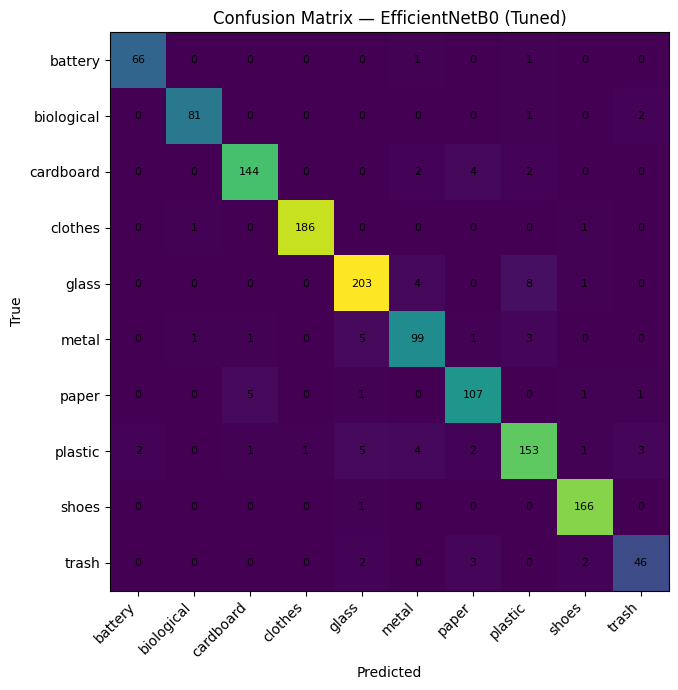

(0.17767295241355896,
 0.9456603527069092,
 0.9441509433962264,
 array([[ 66,   0,   0,   0,   0,   1,   0,   1,   0,   0],
        [  0,  81,   0,   0,   0,   0,   0,   1,   0,   2],
        [  0,   0, 144,   0,   0,   2,   4,   2,   0,   0],
        [  0,   1,   0, 186,   0,   0,   0,   0,   1,   0],
        [  0,   0,   0,   0, 203,   4,   0,   8,   1,   0],
        [  0,   1,   1,   0,   5,  99,   1,   3,   0,   0],
        [  0,   0,   5,   0,   1,   0, 107,   0,   1,   1],
        [  2,   0,   1,   1,   5,   4,   2, 153,   1,   3],
        [  0,   0,   0,   0,   1,   0,   0,   0, 166,   0],
        [  0,   0,   0,   0,   2,   0,   3,   0,   2,  46]]))

In [22]:
evaluate_model(eff_best, test_ds, class_names, title="EfficientNetB0 (Tuned)")

### Overfitting Check — What This Section Does

This part is used to see whether the tuned models (ResNet50 and EfficientNetB0) start to overfit when training continues.

1. Load the tuned models  
   The best versions saved from random search (`resnet50_best.keras` and `efficientnetb0_best.keras`) are loaded for analysis.

2. Create copies of the models  
   Each model is cloned so that the original tuned weights are not modified.  
   This allows us to experiment safely without affecting the final saved models.

3. Train for a few more epochs  
   The copied models are trained for a small number of additional epochs using a low learning rate.  
   This step records both training accuracy and validation accuracy at each epoch.

4. Plot the training and validation curves  
   The graph shows how training accuracy and validation accuracy change over time.  
   The shaded region highlights the gap between them.  
   The final gap (Train − Val) helps indicate how much the model may be overfitting.  
   The dashed vertical line shows the epoch where validation accuracy was highest.

Why this matters:  
If training accuracy keeps increasing while validation accuracy stays flat or drops, it suggests overfitting.  
If both curves remain close and stable, the model is generalizing well.

Epoch 1/15
334/334 - 27s - loss: 0.0066 - accuracy: 0.9992 - val_loss: 0.1982 - val_accuracy: 0.9546 - 27s/epoch - 82ms/step
Epoch 2/15
334/334 - 21s - loss: 0.0049 - accuracy: 0.9995 - val_loss: 0.2082 - val_accuracy: 0.9568 - 21s/epoch - 62ms/step
Epoch 3/15
334/334 - 21s - loss: 0.0048 - accuracy: 0.9993 - val_loss: 0.1991 - val_accuracy: 0.9554 - 21s/epoch - 62ms/step
Epoch 4/15
334/334 - 21s - loss: 0.0038 - accuracy: 0.9999 - val_loss: 0.2038 - val_accuracy: 0.9561 - 21s/epoch - 62ms/step
Epoch 5/15
334/334 - 21s - loss: 0.0047 - accuracy: 0.9993 - val_loss: 0.2171 - val_accuracy: 0.9524 - 21s/epoch - 63ms/step
Epoch 6/15
334/334 - 21s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.2127 - val_accuracy: 0.9613 - 21s/epoch - 63ms/step
Epoch 7/15
334/334 - 21s - loss: 0.0033 - accuracy: 0.9999 - val_loss: 0.2251 - val_accuracy: 0.9606 - 21s/epoch - 63ms/step
Epoch 8/15
334/334 - 21s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.2294 - val_accuracy: 0.9606 - 21s/epoch - 63ms/step


2026-02-19 20:51:37.572403: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb0_search/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 - 23s - loss: 0.0459 - accuracy: 0.9870 - val_loss: 0.1640 - val_accuracy: 0.9464 - 23s/epoch - 69ms/step
Epoch 2/15
334/334 - 14s - loss: 0.0435 - accuracy: 0.9881 - val_loss: 0.1541 - val_accuracy: 0.9524 - 14s/epoch - 43ms/step
Epoch 3/15
334/334 - 14s - loss: 0.0386 - accuracy: 0.9893 - val_loss: 0.1537 - val_accuracy: 0.9539 - 14s/epoch - 42ms/step
Epoch 4/15
334/334 - 14s - loss: 0.0372 - accuracy: 0.9904 - val_loss: 0.1632 - val_accuracy: 0.9494 - 14s/epoch - 43ms/step
Epoch 5/15
334/334 - 14s - loss: 0.0319 - accuracy: 0.9919 - val_loss: 0.1622 - val_accuracy: 0.9531 - 14s/epoch - 43ms/step
Epoch 6/15
334/334 - 14s - loss: 0.0308 - accuracy: 0.9923 - val_loss: 0.1690 - val_accuracy: 0.9435 - 14s/epoch - 43ms/step
Epoch 7/15
334/334 - 15s - loss: 0.0322 - accuracy: 0.9912 - val_loss: 0.1527 - val_accuracy: 0.9539 - 15s/epoch - 43ms/step
Epoch 8/15
334/334 - 15s - loss: 0.0285 - accuracy: 0.9923 - val_loss: 0.1636 - val_accuracy: 0.9509 - 15s/epoch - 44ms/step
Epoch 9/15


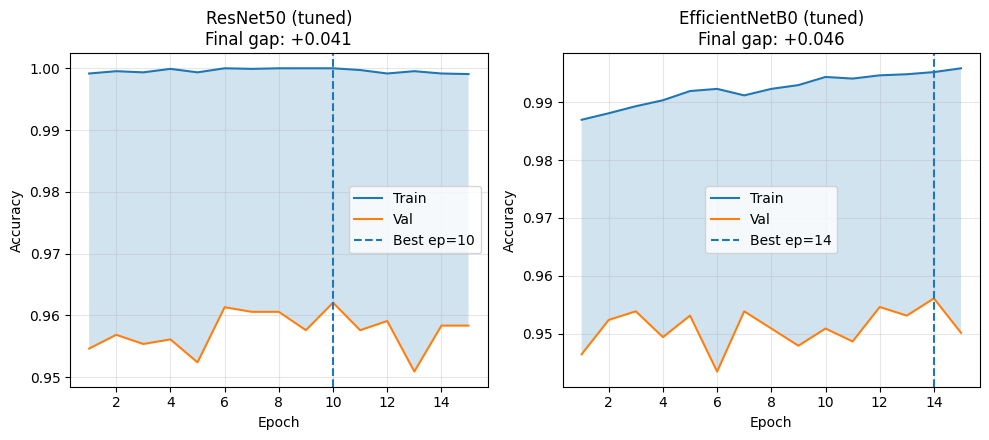

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def copy_model(m):
    m2 = tf.keras.models.clone_model(m)
    m2.set_weights(m.get_weights())
    return m2

def run_curve(m, train_ds, val_ds, epochs=15, lr=1e-5):
    m.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    h = m.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=2)
    return h.history

def plot_train_val_gap(hist_list, titles):
    n = len(hist_list)
    plt.figure(figsize=(5*n, 4.5))

    for idx, (hist, title) in enumerate(zip(hist_list, titles), start=1):
        tr = np.asarray(hist["accuracy"])
        va = np.asarray(hist["val_accuracy"])
        ep = np.arange(1, len(tr) + 1)

        best_ep = int(np.argmax(va)) + 1
        gap = float(tr[-1] - va[-1])

        plt.subplot(1, n, idx)
        plt.plot(ep, tr, label="Train")
        plt.plot(ep, va, label="Val")
        plt.fill_between(ep, va, tr, alpha=0.2)
        plt.axvline(best_ep, linestyle="--", label=f"Best ep={best_ep}")
        plt.title(f"{title}\nFinal gap: {gap:+.3f}")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()


# load tuned models
resnet_best = tf.keras.models.load_model("resnet50_best.keras", safe_mode=False)
eff_best = tf.keras.models.load_model("efficientnetb0_best.keras", safe_mode=False)

# copy them so i don't overwrite the tuned weights
resnet_check = copy_model(resnet_best)
eff_check = copy_model(eff_best)

# run short training to collect curves
EPOCHS = 15
LR = 1e-5

hist_resnet = run_curve(resnet_check, train_ds, val_ds, epochs=EPOCHS, lr=LR)
hist_eff = run_curve(eff_check, train_ds, val_ds, epochs=EPOCHS, lr=LR)

# plot
plot_train_val_gap(
    [hist_resnet, hist_eff],
    ["ResNet50 (tuned)", "EfficientNetB0 (tuned)"]
)

### Model Comparison and Overfitting Summary

Both models were tuned successfully and achieved strong performance on the test set. Overall, ResNet50 performed slightly better than EfficientNetB0.

ResNet50 achieved a test accuracy of 0.9555 with a weighted F1 score of 0.9554. The confusion matrix shows a strong diagonal pattern, meaning most predictions were correct. The misclassifications are small and spread across a few related classes.

EfficientNetB0 achieved a test accuracy of 0.9442 with a weighted F1 score of 0.9440. While performance is still strong, it shows slightly more confusion in classes such as plastic, paper and glass compared to ResNet50.

From the overfitting analysis, both models show a small train–validation gap of around 4–5 percent. Training accuracy is close to 0.999, while validation accuracy remains stable around 0.956–0.957. The validation curve does not collapse or trend downward sharply, which indicates that the overfitting is controlled and not severe.

In summary, both models generalize well, but ResNet50 demonstrates slightly stronger overall performance and more stable validation behaviour. Therefore, ResNet50 can be considered the stronger final model for submission.


# Ensemble the 2 models 

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# load the two tuned models
resnet_model = keras.models.load_model("resnet50_best.keras", safe_mode=False)
eff_model = keras.models.load_model("efficientnetb0_best.keras", safe_mode=False)

# create a shared input layer (same shape as the trained models)
input_layer = keras.Input(shape=resnet_model.input_shape[1:])

# get predictions from both models
resnet_preds = resnet_model(input_layer, training=False)
eff_preds = eff_model(input_layer, training=False)

# average their softmax outputs
ensemble_output = keras.layers.Average()([resnet_preds, eff_preds])

# define the ensemble model
ensemble_model = keras.Model(inputs=input_layer, outputs=ensemble_output)

# compile so we can evaluate it normally
ensemble_model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

# evaluate ensemble on test set
test_loss, test_acc = ensemble_model.evaluate(test_ds, verbose=1)
print(f"\nEnsemble results — loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

# save as final model
ensemble_model.save("final_model.keras")

# reload to confirm it works
final_model = keras.models.load_model("final_model.keras", safe_mode=False)
print("Final model loaded successfully.")


42/42 [==============================] - 7s 72ms/step - loss: 0.1347 - accuracy: 0.9585

Ensemble results — loss: 0.1347, accuracy: 0.9585


Final model loaded successfully.


In [29]:
w_resnet = 0.6
w_eff = 0.4
avg = keras.layers.Lambda(lambda z: w_resnet*z[0] + w_eff*z[1], name="weighted_avg")([p1, p2])

42/42 [==============================] - 9s 74ms/step - loss: 0.1371 - accuracy: 0.9585

Ensemble (ResNet50 + EfficientNetB0) — loss: 0.1371, accuracy: 0.9585
Ensemble (ResNet50 + EfficientNetB0) — accuracy_score: 0.9623

              precision    recall  f1-score   support

     battery     0.9718    0.9718    0.9718        71
  biological     1.0000    0.9718    0.9857        71
   cardboard     0.9796    0.9600    0.9697       150
     clothes     1.0000    0.9949    0.9974       195
       glass     0.9459    0.9677    0.9567       217
       metal     0.9381    0.9464    0.9422       112
       paper     0.9274    0.9664    0.9465       119
     plastic     0.9497    0.9096    0.9292       166
       shoes     0.9714    0.9942    0.9827       171
       trash     0.9216    0.8868    0.9038        53

    accuracy                         0.9623      1325
   macro avg     0.9606    0.9570    0.9586      1325
weighted avg     0.9624    0.9623    0.9622      1325



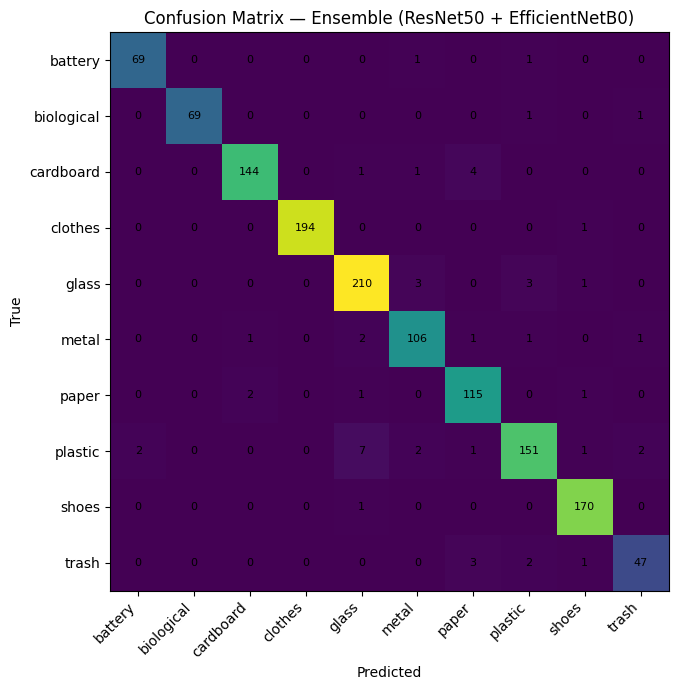

(0.13705162703990936,
 0.9584905505180359,
 0.9622641509433962,
 array([[ 69,   0,   0,   0,   0,   1,   0,   1,   0,   0],
        [  0,  69,   0,   0,   0,   0,   0,   1,   0,   1],
        [  0,   0, 144,   0,   1,   1,   4,   0,   0,   0],
        [  0,   0,   0, 194,   0,   0,   0,   0,   1,   0],
        [  0,   0,   0,   0, 210,   3,   0,   3,   1,   0],
        [  0,   0,   1,   0,   2, 106,   1,   1,   0,   1],
        [  0,   0,   2,   0,   1,   0, 115,   0,   1,   0],
        [  2,   0,   0,   0,   7,   2,   1, 151,   1,   2],
        [  0,   0,   0,   0,   1,   0,   0,   0, 170,   0],
        [  0,   0,   0,   0,   0,   0,   3,   2,   1,  47]]))

In [30]:
# get class names from dataset
class_names = train_ds.class_names

# load ensemble model (or use ensemble_model if still in memory)
ensemble_model = tf.keras.models.load_model("final_model.keras", safe_mode=False)

# evaluate with full report + confusion matrix
evaluate_model(
    ensemble_model,
    test_ds,
    class_names,
    title="Ensemble (ResNet50 + EfficientNetB0)"
)

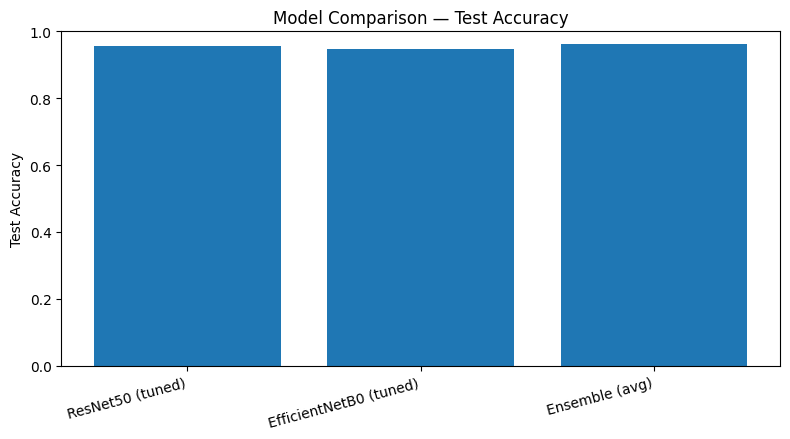

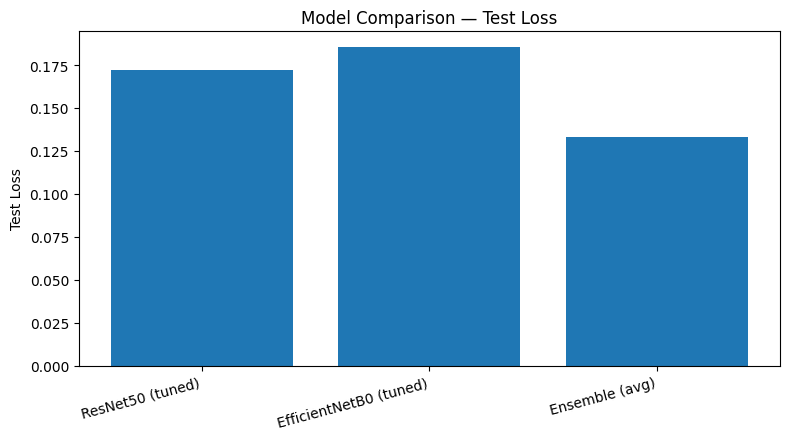

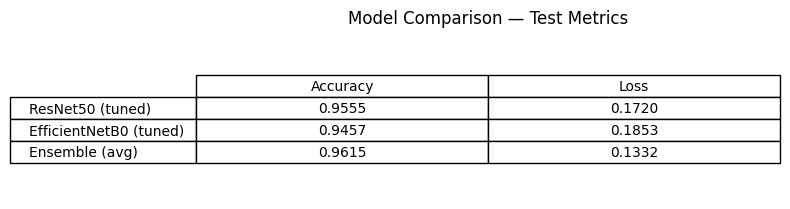

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

resnet_model = keras.models.load_model("resnet50_best.keras", safe_mode=False)
eff_model    = keras.models.load_model("efficientnetb0_best.keras", safe_mode=False)
ens_model    = keras.models.load_model("final_model.keras", safe_mode=False)

models = [
    ("ResNet50 (tuned)", resnet_model),
    ("EfficientNetB0 (tuned)", eff_model),
    ("Ensemble (avg)", ens_model),
]

def get_metrics(m):
    loss, acc = m.evaluate(test_ds, verbose=0)
    return float(loss), float(acc)

names = []
losses = []
accs = []

for name, m in models:
    l, a = get_metrics(m)
    names.append(name)
    losses.append(l)
    accs.append(a)

# --- A) Bar chart: accuracy
plt.figure(figsize=(8,4.5))
plt.bar(names, accs)
plt.ylabel("Test Accuracy")
plt.ylim(0.0, 1.0)
plt.title("Model Comparison — Test Accuracy")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

# --- B) Bar chart: loss
plt.figure(figsize=(8,4.5))
plt.bar(names, losses)
plt.ylabel("Test Loss")
plt.title("Model Comparison — Test Loss")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

# --- C) Simple results table (visual)
plt.figure(figsize=(8,2.2))
plt.axis("off")
table_data = [[f"{a:.4f}", f"{l:.4f}"] for a, l in zip(accs, losses)]
tbl = plt.table(
    cellText=table_data,
    rowLabels=names,
    colLabels=["Accuracy", "Loss"],
    cellLoc="center",
    loc="center"
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.4)
plt.title("Model Comparison — Test Metrics", pad=12)
plt.tight_layout()
plt.show()

In [33]:
import tensorflow as tf
from tensorflow import keras

# --- load your final model (ensemble) OR switch to resnet50_best.keras if you prefer single model
model = keras.models.load_model("final_model.keras", safe_mode=False)

# --- save labels in the correct order (critical)
with open("labels.txt", "w") as f:
    for name in train_ds.class_names:
        f.write(name + "\n")

print("Saved labels.txt with", len(train_ds.class_names), "classes")

# --- convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open("final_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Saved final_model.tflite")

Saved labels.txt with 10 classes
INFO:tensorflow:Assets written to: /tmp/tmpb598lum0/assets


INFO:tensorflow:Assets written to: /tmp/tmpb598lum0/assets
2026-02-19 21:44:33.001077: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2026-02-19 21:44:33.001135: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2026-02-19 21:44:33.001874: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpb598lum0
2026-02-19 21:44:33.140631: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2026-02-19 21:44:33.140668: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpb598lum0
2026-02-19 21:44:33.442478: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2026-02-19 21:44:33.580481: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2026-02-19 21:44:36.413836: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

Saved final_model.tflite
